In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install pyspark==3.5.0

E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/main/o/openjdk-lts/openjdk-11-jre-headless_11.0.28%2b6-1ubuntu1%7e22.04.1_amd64.deb  404  Not Found [IP: 185.125.190.36 80]
E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/main/o/openjdk-lts/openjdk-11-jdk-headless_11.0.28%2b6-1ubuntu1%7e22.04.1_amd64.deb  404  Not Found [IP: 185.125.190.36 80]
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425346 sha256=105417bd14679392f6efc503c77c69e491247b7c1363362c4558628411df3d3d
  Stored in directory: /root/.cache/pip/wheels/84/40/20/65eefe766118e0a8f8e385cc3ed6e9eb7241c7e51cfc04c51a
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully unin

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.appName("da231o_project_1") \
  .config("spark.executor.memory", "20g") \
  .config("spark.driver.memory", "20g") \
  .getOrCreate()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
gw1 = spark.read.csv("/kaggle/input/data-engineering/gw1.csv", header=True)
teams = spark.read.csv("/kaggle/input/data-engineering/teams.csv", header=True)
teams.show()

+----+----+----+---+----+--------------+------+------+--------+----------+--------+-------------+-----------+---+---------------------+---------------------+--------------------+--------------------+---------------------+---------------------+--------+
|code|draw|form| id|loss|          name|played|points|position|short_name|strength|team_division|unavailable|win|strength_overall_home|strength_overall_away|strength_attack_home|strength_attack_away|strength_defence_home|strength_defence_away|pulse_id|
+----+----+----+---+----+--------------+------+------+--------+----------+--------+-------------+-----------+---+---------------------+---------------------+--------------------+--------------------+---------------------+---------------------+--------+
|   3|   0|NULL|  1|   0|       Arsenal|     0|     0|       2|       ARS|       5|         NULL|      False|  0|                 1350|                 1350|                1390|                1400|                 1310|                 130

# Pre-Processing & Feature Engineering

### Players Data Summary for each 38 weeks

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, DateType
from pyspark.sql import functions as F

# CREATING EMPTY SCHEMA

# Defining the schema
schema = StructType([
    StructField("name", StringType(), True),
    StructField("position", StringType(), True),
    StructField("team", StringType(), True),
    StructField("assists", IntegerType(), True),
   # StructField("bonus", StringType(), True),
    StructField("clean_sheets", IntegerType(), True),
   # StructField("fixture", StringType(), True),
    StructField("goals_conceded", IntegerType(), True),
    StructField("goals_scored", IntegerType(), True),
    StructField("minutes", IntegerType(), True),
    StructField("opponent_team", StringType(), True),
    StructField("own_goals", IntegerType(), True),
    StructField("penalties_missed", IntegerType(), True),
    StructField("penalties_saved", IntegerType(), True),
    StructField("red_cards", IntegerType(), True),
    StructField("saves", IntegerType(), True),
    StructField("team_a_score", IntegerType(), True),
    StructField("team_h_score", IntegerType(), True),
    StructField("was_home", StringType(), True),
    StructField("yellow_cards", IntegerType(), True),
    StructField("GameWeek", StringType(), True),
    StructField("MatchDate", DateType(), True),
    StructField("HasPlayed", StringType(), True)
])

merged_GW_df = spark.createDataFrame([], schema)


for i in range(1,39):
  file_path = f"/kaggle/input/data-engineering/gw{i}.csv"
  temp_df = spark.read.csv(file_path, header=True)

  # Add new columns and modify existing
  temp_df = temp_df.withColumn("GameWeek", F.lit(f"gw{i}"))
  temp_df = temp_df.withColumn("MatchDate", F.to_date("kickoff_time"))
  temp_df = temp_df.withColumn("HasPlayed", F.when(temp_df["minutes"] > 0, "Yes").otherwise("No"))

  # Drop unwanted columns
  cols_to_drop = ["xP", "bps", "creativity", "element", "bonus", "fixture", "expected_assists", "expected_goal_involvements", "kickoff_time", "expected_goals", "expected_goals_conceded", "modified", "influence", "round", "selected", "starts", "threat", "total_points", "ict_index", "transfers_balance", "transfers_in", "transfers_out", "value"]
  temp_df = temp_df.drop(*cols_to_drop)


  # Select only the columns defined in the schema to ensure consistency
  temp_df = temp_df.select(*[col for col in schema.fieldNames()])


  # Append the processed temporary DataFrame to the merged_GW_df
  merged_GW_df = merged_GW_df.unionAll(temp_df)


merged_GW_df.show()

+--------------------+--------+--------------+-------+------------+--------------+------------+-------+-------------+---------+----------------+---------------+---------+-----+------------+------------+--------+------------+--------+----------+---------+
|                name|position|          team|assists|clean_sheets|goals_conceded|goals_scored|minutes|opponent_team|own_goals|penalties_missed|penalties_saved|red_cards|saves|team_a_score|team_h_score|was_home|yellow_cards|GameWeek| MatchDate|HasPlayed|
+--------------------+--------+--------------+-------+------------+--------------+------------+-------+-------------+---------+----------------+---------------+---------+-----+------------+------------+--------+------------+--------+----------+---------+
|          Alex Scott|     MID|   Bournemouth|      0|           0|             1|           0|     62|           16|        0|               0|              0|        0|    0|           1|           1|   False|           0|     gw1|20

In [ ]:
#filtering for a particular player
merged_GW_df.filter(F.col("name") == "Cole Palmer").show(5)

+-----------+--------+-------+-------+------------+--------------+------------+-------+-------------+---------+----------------+---------------+---------+-----+------------+------------+--------+------------+--------+----------+---------+
|       name|position|   team|assists|clean_sheets|goals_conceded|goals_scored|minutes|opponent_team|own_goals|penalties_missed|penalties_saved|red_cards|saves|team_a_score|team_h_score|was_home|yellow_cards|GameWeek| MatchDate|HasPlayed|
+-----------+--------+-------+-------+------------+--------------+------------+-------+-------------+---------+----------------+---------------+---------+-----+------------+------------+--------+------------+--------+----------+---------+
|Cole Palmer|     MID|Chelsea|      0|           0|             2|           0|     90|           13|        0|               0|              0|        0|    0|           2|           0|    True|           0|     gw1|2024-08-18|      Yes|
|Cole Palmer|     MID|Chelsea|      3|      

In [ ]:
# Total number of Row and Columns for merged_GW_df
num_rows = merged_GW_df.count()
num_cols = len(merged_GW_df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 27605
Number of columns: 21


### Fantasy Points for each Player

🧮 Fantasy Points Scoring Logic

| Action Type            | Action / Event        | Points (per event) | Player Position(s)        | Notes |
| ---------------------- | -------------------- | ------------------ | ------------------------- | ----- |
| Appearance             | Played up to 50 mins | 1                  | All                       | Awarded if `minutes` > 0 and ≤ 50 |
| Appearance             | Played > 50 mins     | 2                  | All                       | Awarded if `minutes` > 50 |
| Goal                   | Goal scored          | 6                  | GK, DEF                   | `goal_points = goals_scored * 6` |
| Goal                   | Goal scored          | 5                  | MID                       | `goal_points = goals_scored * 5` |
| Goal                   | Goal scored          | 4                  | FWD                       | `goal_points = goals_scored * 4` |
| Assist                 | Assist made          | 4                  | GK, DEF                   | `assist_points = assists * 4` |
| Assist                 | Assist made          | 3                  | MID                       | `assist_points = assists * 3` |
| Assist                 | Assist made          | 2                  | FWD                       | `assist_points = assists * 2` |
| Clean Sheet            | Clean sheet          | 4                  | GK, DEF                   | Awarded if `clean_sheets` == 1 |
| Clean Sheet            | Clean sheet          | 1                  | MID                       | Optional — awarded if `clean_sheets` == 1 |
| Defensive              | Goals conceded       | -1 per 2 conceded  | GK, DEF                   | `goals_conceded_points = floor(goals_conceded / 2) * -1` |
| Penalty                | Penalty saved        | +5                 | GK                        | `penalty_saved_points = penalties_saved * 5` |
| Penalty                | Penalty missed       | -2                 | All                       | `penalty_missed_points = penalties_missed * -2` |
| Discipline             | Yellow card          | -1                 | All                       | `yellow_card_points = yellow_cards * -1` |
| Discipline             | Red card             | -3                 | All                       | `red_card_points = red_cards * -3` |
| Own Goal               | Own goal scored      | -2                 | All                       | `own_goal_points = own_goals * -2` |
| Saves                  | Saves made           | +1 per 3 saves     | GK                        | `save_points = floor(saves / 3) * 1` |

---
---

**🧾 Total FantasyPoints Formula**  = *minutes_points + goal_points + assist_points + clean_sheet_points +
goals_conceded_points + penalty_saved_points + penalty_missed_points +
yellow_card_points + red_card_points + own_goal_points + save_points*


In [ ]:
from pyspark.sql import functions as F

df_FantasyPoints = (
    merged_GW_df
    .withColumn("minutes_points",
                F.when((F.col("minutes") > 0) & (F.col("minutes") <= 50), 1)
                 .when(F.col("minutes") > 50, 2)
                 .otherwise(0))
    .withColumn("goal_points",
                F.when(F.col("position") == "GK", F.col("goals_scored") * 6)
                 .when(F.col("position") == "DEF", F.col("goals_scored") * 6)
                 .when(F.col("position") == "MID", F.col("goals_scored") * 5)
                 .when(F.col("position") == "FWD", F.col("goals_scored") * 4)
                 .otherwise(0))
    .withColumn("assist_points", F.when(F.col("position") == "GK", F.col("assists") * 4)
                 .when(F.col("position") == "DEF", F.col("assists") * 4)
                 .when(F.col("position") == "MID", F.col("assists") * 3)
                 .when(F.col("position") == "FWD", F.col("assists") * 2)
                 .otherwise(0))
    .withColumn("clean_sheet_points",
                F.when((F.col("position").isin("GK", "DEF")) & (F.col("clean_sheets") > 0), 4)
                 .when((F.col("position") == "MID") & (F.col("clean_sheets") > 0), 1)
                 .otherwise(0))
    .withColumn("goals_conceded_points",
                F.when(F.col("position").isin("GK", "DEF"), -1 * (F.floor(F.col("goals_conceded") / 2)))
                 .otherwise(0))
    .withColumn("penalty_saved_points", F.col("penalties_saved") * 5)
    .withColumn("penalty_missed_points", F.col("penalties_missed") * -2)
    .withColumn("yellow_card_points", F.col("yellow_cards") * -1)
    .withColumn("red_card_points", F.col("red_cards") * -3)
    .withColumn("own_goal_points", F.col("own_goals") * -2)
    .withColumn("save_points", F.floor(F.col("saves") / 3))
    .withColumn(
        "FantasyPoints",
        F.expr(
            "minutes_points + goal_points + assist_points + clean_sheet_points + "
            "goals_conceded_points + penalty_saved_points + penalty_missed_points + "
            "yellow_card_points + red_card_points + own_goal_points + save_points"
        )
    )
)

df_FantasyPoints.show()

25/11/26 14:02:35 WARN DAGScheduler: Broadcasting large task binary with size 1654.8 KiB
25/11/26 14:02:35 WARN DAGScheduler: Broadcasting large task binary with size 1654.8 KiB


+--------------------+--------+--------------+-------+------------+--------------+------------+-------+-------------+---------+----------------+---------------+---------+-----+------------+------------+--------+------------+--------+----------+---------+--------------+-----------+-------------+------------------+---------------------+--------------------+---------------------+------------------+---------------+---------------+-----------+-------------+
|                name|position|          team|assists|clean_sheets|goals_conceded|goals_scored|minutes|opponent_team|own_goals|penalties_missed|penalties_saved|red_cards|saves|team_a_score|team_h_score|was_home|yellow_cards|GameWeek| MatchDate|HasPlayed|minutes_points|goal_points|assist_points|clean_sheet_points|goals_conceded_points|penalty_saved_points|penalty_missed_points|yellow_card_points|red_card_points|own_goal_points|save_points|FantasyPoints|
+--------------------+--------+--------------+-------+------------+--------------+----

In [ ]:
#filtering for a particular team
df_FantasyPoints.filter(F.col("team") == "Arsenal").show(5)

25/11/26 14:02:38 WARN DAGScheduler: Broadcasting large task binary with size 1674.4 KiB
25/11/26 14:02:38 WARN DAGScheduler: Broadcasting large task binary with size 1674.4 KiB


+--------------------+--------+-------+-------+------------+--------------+------------+-------+-------------+---------+----------------+---------------+---------+-----+------------+------------+--------+------------+--------+----------+---------+--------------+-----------+-------------+------------------+---------------------+--------------------+---------------------+------------------+---------------+---------------+-----------+-------------+
|                name|position|   team|assists|clean_sheets|goals_conceded|goals_scored|minutes|opponent_team|own_goals|penalties_missed|penalties_saved|red_cards|saves|team_a_score|team_h_score|was_home|yellow_cards|GameWeek| MatchDate|HasPlayed|minutes_points|goal_points|assist_points|clean_sheet_points|goals_conceded_points|penalty_saved_points|penalty_missed_points|yellow_card_points|red_card_points|own_goal_points|save_points|FantasyPoints|
+--------------------+--------+-------+-------+------------+--------------+------------+-------+----

In [ ]:
# Total number of Row and Columns for df_FantasyPoints
num_rows = df_FantasyPoints.count()
num_cols = len(df_FantasyPoints.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 27605
Number of columns: 33


In [ ]:
##filtering for GameWeek, GW1 to find which player got most points
df_FantasyPoints.filter(F.col("GameWeek") == "gw1").orderBy(F.desc("FantasyPoints")).show(5)

+-------------+--------+---------+-------+------------+--------------+------------+-------+-------------+---------+----------------+---------------+---------+-----+------------+------------+--------+------------+--------+----------+---------+--------------+-----------+-------------+------------------+---------------------+--------------------+---------------------+------------------+---------------+---------------+-----------+-------------+
|         name|position|     team|assists|clean_sheets|goals_conceded|goals_scored|minutes|opponent_team|own_goals|penalties_missed|penalties_saved|red_cards|saves|team_a_score|team_h_score|was_home|yellow_cards|GameWeek| MatchDate|HasPlayed|minutes_points|goal_points|assist_points|clean_sheet_points|goals_conceded_points|penalty_saved_points|penalty_missed_points|yellow_card_points|red_card_points|own_goal_points|save_points|FantasyPoints|
+-------------+--------+---------+-------+------------+--------------+------------+-------+-------------+-----

### Players data for Whole season groupBy("name", "position", "team")

In [ ]:
from pyspark.sql import functions as F

player_summary_wholeSeason_df = (
    df_FantasyPoints.groupBy("name", "position", "team")
      .agg(
          F.sum("assists").alias("TotalAssists"),
          F.sum("clean_sheets").alias("TotalCleanSheets"),
          F.sum("goals_conceded").alias("TotalGoalsConceded"),
          F.sum("goals_scored").alias("TotalGoalsScored"),
          F.sum("minutes").alias("TotalMinutes"),
          F.sum("own_goals").alias("TotalOwnGoals"),
          F.sum("penalties_missed").alias("TotalPenaltiesMissed"),
          F.sum("penalties_saved").alias("TotalPenaltiesSaved"),
          F.sum("red_cards").alias("TotalRedCards"),
          F.sum("saves").alias("TotalSaves"),
          F.sum("yellow_cards").alias("TotalYellowCards"),
          F.sum("FantasyPoints").alias("TotalFantasyPoints")
      )
)

player_summary_wholeSeason_df.show()

25/11/26 14:02:43 WARN DAGScheduler: Broadcasting large task binary with size 1782.9 KiB
25/11/26 14:02:47 WARN DAGScheduler: Broadcasting large task binary with size 1056.7 KiB


+--------------------+--------+--------------+------------+----------------+------------------+----------------+------------+-------------+--------------------+-------------------+-------------+----------+----------------+------------------+
|                name|position|          team|TotalAssists|TotalCleanSheets|TotalGoalsConceded|TotalGoalsScored|TotalMinutes|TotalOwnGoals|TotalPenaltiesMissed|TotalPenaltiesSaved|TotalRedCards|TotalSaves|TotalYellowCards|TotalFantasyPoints|
+--------------------+--------+--------------+------------+----------------+------------------+----------------+------------+-------------+--------------------+-------------------+-------------+----------+----------------+------------------+
|         Kyle Walker|     DEF|      Man City|         0.0|             0.0|              21.0|             0.0|       966.0|          0.0|                 0.0|                0.0|          0.0|       0.0|             3.0|              13.0|
|        Toby Collyer|     MID| 

In [ ]:
# Total number of Row and Columns for player_summary_wholeSeason_df
num_rows = player_summary_wholeSeason_df.count()
num_cols = len(player_summary_wholeSeason_df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 834
Number of columns: 15


In [ ]:
player_summary_wholeSeason_df.orderBy(F.desc("TotalGoalsScored")).show()

25/11/26 14:02:51 WARN DAGScheduler: Broadcasting large task binary with size 1784.8 KiB
25/11/26 14:02:54 WARN DAGScheduler: Broadcasting large task binary with size 1056.0 KiB


+--------------------+--------+--------------+------------+----------------+------------------+----------------+------------+-------------+--------------------+-------------------+-------------+----------+----------------+------------------+
|                name|position|          team|TotalAssists|TotalCleanSheets|TotalGoalsConceded|TotalGoalsScored|TotalMinutes|TotalOwnGoals|TotalPenaltiesMissed|TotalPenaltiesSaved|TotalRedCards|TotalSaves|TotalYellowCards|TotalFantasyPoints|
+--------------------+--------+--------------+------------+----------------+------------------+----------------+------------+-------------+--------------------+-------------------+-------------+----------+----------------+------------------+
|       Mohamed Salah|     MID|     Liverpool|        18.0|            15.0|              40.0|            29.0|      3374.0|          0.0|                 0.0|                0.0|          0.0|       0.0|             1.0|             289.0|
|      Alexander Isak|     FWD| 

### Math Results for 38 Game Weeks

In [ ]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

# Define the schema for the final match results DataFrame
match_results_schema = StructType([
    StructField("GameWeek", StringType(), True),
    StructField("Team", StringType(), True),
    StructField("OpponentTeam", StringType(), True),
    StructField("was_home", StringType(), True),
    StructField("Team Score", IntegerType(), True),
    StructField("OpponentTeam Score", IntegerType(), True),
    StructField("Result", StringType(), True)
])

# Create an empty Spark DataFrame with the defined schema
all_gameweek_matchesResult_df = spark.createDataFrame([], match_results_schema)

In [ ]:
# Loop through each gameweek file from 1 to 38
for i in range(1, 39):
  file_path = f"/kaggle/input/data-engineering/gw{i}.csv"

  # Load the current gameweek CSV
  temp_df = spark.read.csv(file_path, header=True)

  # Add the 'GameWeek' column
  temp_df = temp_df.withColumn("GameWeek", F.lit(f"gw{i}"))

  # Select the necessary columns for match results and get distinct combinations
  distinct_combinations = temp_df.select("team", "opponent_team", "team_a_score", "team_h_score", "was_home", "GameWeek").distinct()

  # Join distinct_combinations with teams DataFrame to get opponent team names
  distinct_combinations_with_names = distinct_combinations.join(
      teams.selectExpr("id", "name as OpponentTeam"),
      distinct_combinations["opponent_team"] == teams["id"],
      "left"
  ).drop(teams["id"])

  # Create 'Team Score' and 'OpponentTeam Score' columns
  distinct_combinations_with_scores = distinct_combinations_with_names.withColumn(
      "Team Score",
      F.when(distinct_combinations_with_names["was_home"] == "True", distinct_combinations_with_names["team_h_score"])
      .otherwise(distinct_combinations_with_names["team_a_score"])
  ).withColumn(
      "OpponentTeam Score",
      F.when(distinct_combinations_with_names["was_home"] == "True", distinct_combinations_with_names["team_a_score"])
      .otherwise(distinct_combinations_with_names["team_h_score"])
  )

  # Create 'Result' column based on 'Team Score' and 'OpponentTeam Score'
  distinct_combinations_with_results = distinct_combinations_with_scores.withColumn( # Reference distinct_combinations_with_scores here
      "Result",
      F.when(distinct_combinations_with_scores["Team Score"] > distinct_combinations_with_scores["OpponentTeam Score"], "Win") # Reference distinct_combinations_with_scores here
      .when(distinct_combinations_with_scores["Team Score"] < distinct_combinations_with_scores["OpponentTeam Score"], "Loss") # Reference distinct_combinations_with_scores here
      .otherwise("Draw")
  )

  # Select columns that uniquely identify a match and get distinct combinations
  # and rename the 'team' column name
  gameweek_matches_df = distinct_combinations_with_results.select(
      "GameWeek",
      "team",
      "OpponentTeam",
      "was_home",
      F.col("Team Score").cast(IntegerType()).alias("Team Score"), # Cast to IntegerType
      F.col("OpponentTeam Score").cast(IntegerType()).alias("OpponentTeam Score"), # Cast to IntegerType
      "Result"
  ).distinct().withColumnRenamed("team", "Team")

  # Append the processed gameweek DataFrame to the main DataFrame
  all_gameweek_matchesResult_df = all_gameweek_matchesResult_df.unionAll(gameweek_matches_df)

# Show the final DataFrame containing match results for all 38 gameweeks
all_gameweek_matchesResult_df.show()

25/11/26 14:03:09 WARN DAGScheduler: Broadcasting large task binary with size 1636.3 KiB
25/11/26 14:03:09 WARN DAGScheduler: Broadcasting large task binary with size 1636.3 KiB


+--------+--------------+--------------+--------+----------+------------------+------+
|GameWeek|          Team|  OpponentTeam|was_home|Team Score|OpponentTeam Score|Result|
+--------+--------------+--------------+--------+----------+------------------+------+
|     gw1|     Leicester|         Spurs|    True|         1|                 1|  Draw|
|     gw1|      Brighton|       Everton|   False|         3|                 0|   Win|
|     gw1|     Liverpool|       Ipswich|   False|         2|                 0|   Win|
|     gw1|        Wolves|       Arsenal|   False|         0|                 2|  Loss|
|     gw1|        Fulham|       Man Utd|   False|         0|                 1|  Loss|
|     gw1|   Southampton|     Newcastle|   False|         0|                 1|  Loss|
|     gw1|      Man City|       Chelsea|   False|         2|                 0|   Win|
|     gw1|       Everton|      Brighton|    True|         0|                 3|  Loss|
|     gw1|      West Ham|   Aston Villa|   

25/11/26 14:03:09 WARN DAGScheduler: Broadcasting large task binary with size 1636.3 KiB


In [ ]:
from pyspark.sql import functions as F

# Create a concise match ID using the first 3 letters of each team name
all_gameweek_matchesResult_df = all_gameweek_matchesResult_df.withColumn(
    "match_id",
    F.concat_ws("_",
        F.substring(F.least("Team", "OpponentTeam"), 1, 3),
        F.substring(F.greatest("Team", "OpponentTeam"), 1, 3),
        F.regexp_replace("GameWeek", "gw", "")  # optional: shorten gw1 -> 1
    )
)

# Keep only one record per unique match (e.g., the home team’s version)
all_gameweek_matchesResult_df = (
    all_gameweek_matchesResult_df
    .dropDuplicates(["match_id"])
)

# Extract the numeric part from "gw1", "gw2", ... and cast to integer
all_gameweek_matchesResult_df = all_gameweek_matchesResult_df.withColumn(
    "GameWeekNum",
    F.regexp_replace("GameWeek", "gw", "").cast("int")
)

# Now sort by the numeric week, optionally also by team name
all_gameweek_matchesResult_df = all_gameweek_matchesResult_df.orderBy("GameWeekNum", "Team")

# Show the final cleaned result
all_gameweek_matchesResult_df.show()


25/11/26 14:03:15 WARN DAGScheduler: Broadcasting large task binary with size 1731.2 KiB


+--------+--------------+------------+--------+----------+------------------+------+---------+-----------+
|GameWeek|          Team|OpponentTeam|was_home|Team Score|OpponentTeam Score|Result| match_id|GameWeekNum|
+--------+--------------+------------+--------+----------+------------------+------+---------+-----------+
|     gw1|      Brighton|     Everton|   False|         3|                 0|   Win|Bri_Eve_1|          1|
|     gw1|Crystal Palace|   Brentford|   False|         1|                 2|  Loss|Bre_Cry_1|          1|
|     gw1|        Fulham|     Man Utd|   False|         0|                 1|  Loss|Ful_Man_1|          1|
|     gw1|     Leicester|       Spurs|    True|         1|                 1|  Draw|Lei_Spu_1|          1|
|     gw1|     Liverpool|     Ipswich|   False|         2|                 0|   Win|Ips_Liv_1|          1|
|     gw1|      Man City|     Chelsea|   False|         2|                 0|   Win|Che_Man_1|          1|
|     gw1| Nott'm Forest| Bournemouth

25/11/26 14:03:18 WARN DAGScheduler: Broadcasting large task binary with size 1066.2 KiB


In [ ]:
# Total number of Row and Columns for all_gameweek_matchesResult_df
num_rows1 = all_gameweek_matchesResult_df.count()
num_cols1 = len(all_gameweek_matchesResult_df.columns)

print(f"Number of rows: {num_rows1}")
print(f"Number of columns: {num_cols1}")

25/11/26 14:03:23 WARN DAGScheduler: Broadcasting large task binary with size 1657.7 KiB
25/11/26 14:03:25 WARN DAGScheduler: Broadcasting large task binary with size 1031.6 KiB


Number of rows: 380
Number of columns: 9


# EDA

### Fantasay Points Analysis

In [ ]:
position_fantasy_points = player_summary_wholeSeason_df.groupBy("position").agg(
    F.sum("TotalFantasyPoints").alias("TotalFantasyPointsByPosition"),
    F.avg("TotalFantasyPoints").alias("AverageFantasyPointsByPosition")
)

position_fantasy_points.orderBy(F.desc("TotalFantasyPointsByPosition")).show()
position_fantasy_points.orderBy(F.desc("AverageFantasyPointsByPosition")).show()



25/11/26 14:03:27 WARN DAGScheduler: Broadcasting large task binary with size 1678.0 KiB
25/11/26 14:03:30 WARN DAGScheduler: Broadcasting large task binary with size 1005.6 KiB
25/11/26 14:03:31 WARN DAGScheduler: Broadcasting large task binary with size 1002.0 KiB


+--------+----------------------------+------------------------------+
|position|TotalFantasyPointsByPosition|AverageFantasyPointsByPosition|
+--------+----------------------------+------------------------------+
|     MID|                     14514.0|             40.31666666666667|
|     DEF|                      8911.0|            32.403636363636366|
|     FWD|                      3416.0|             37.53846153846154|
|      GK|                      2406.0|            27.655172413793103|
|      AM|                         0.0|                           0.0|
+--------+----------------------------+------------------------------+



25/11/26 14:03:33 WARN DAGScheduler: Broadcasting large task binary with size 1678.0 KiB
25/11/26 14:03:35 WARN DAGScheduler: Broadcasting large task binary with size 1006.0 KiB


+--------+----------------------------+------------------------------+
|position|TotalFantasyPointsByPosition|AverageFantasyPointsByPosition|
+--------+----------------------------+------------------------------+
|     MID|                     14514.0|             40.31666666666667|
|     FWD|                      3416.0|             37.53846153846154|
|     DEF|                      8911.0|            32.403636363636366|
|      GK|                      2406.0|            27.655172413793103|
|      AM|                         0.0|                           0.0|
+--------+----------------------------+------------------------------+



25/11/26 14:03:35 WARN DAGScheduler: Broadcasting large task binary with size 1002.0 KiB


**Replacing position *AM* with *MID* as attacking midfilder is part of Midfilder setup**

In [ ]:
# Replace 'AM' position with 'MID'
position_fantasy_points = position_fantasy_points.withColumn(
    "position",
    F.when(F.col("position") == "AM", "MID").otherwise(F.col("position"))
)


***CONVERTING THE DATAFRAMES INTO PANDAS TO PLOT GRAPH, TO EXTRACT INFORMATION FROM THE GRAPH***

25/11/26 14:03:37 WARN DAGScheduler: Broadcasting large task binary with size 1678.0 KiB
25/11/26 14:03:39 WARN DAGScheduler: Broadcasting large task binary with size 1006.0 KiB
25/11/26 14:03:39 WARN DAGScheduler: Broadcasting large task binary with size 1000.8 KiB


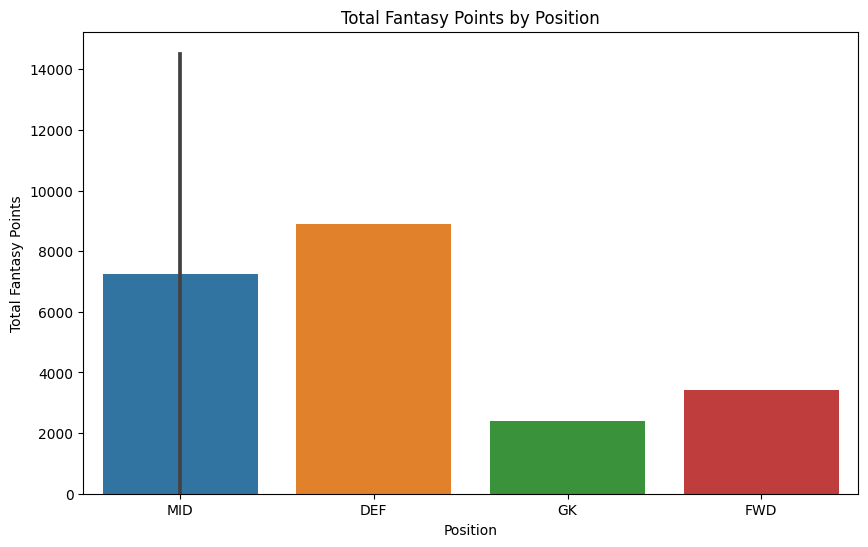

In [ ]:
# Convert to pandas DataFrame for plotting
position_fantasy_points_pd = position_fantasy_points.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="position", y="TotalFantasyPointsByPosition", data=position_fantasy_points_pd)
plt.title("Total Fantasy Points by Position")
plt.xlabel("Position")
plt.ylabel("Total Fantasy Points")
plt.show()

25/11/26 14:03:48 WARN DAGScheduler: Broadcasting large task binary with size 1672.9 KiB
25/11/26 14:03:51 WARN DAGScheduler: Broadcasting large task binary with size 1049.2 KiB
25/11/26 14:03:52 WARN DAGScheduler: Broadcasting large task binary with size 1045.9 KiB


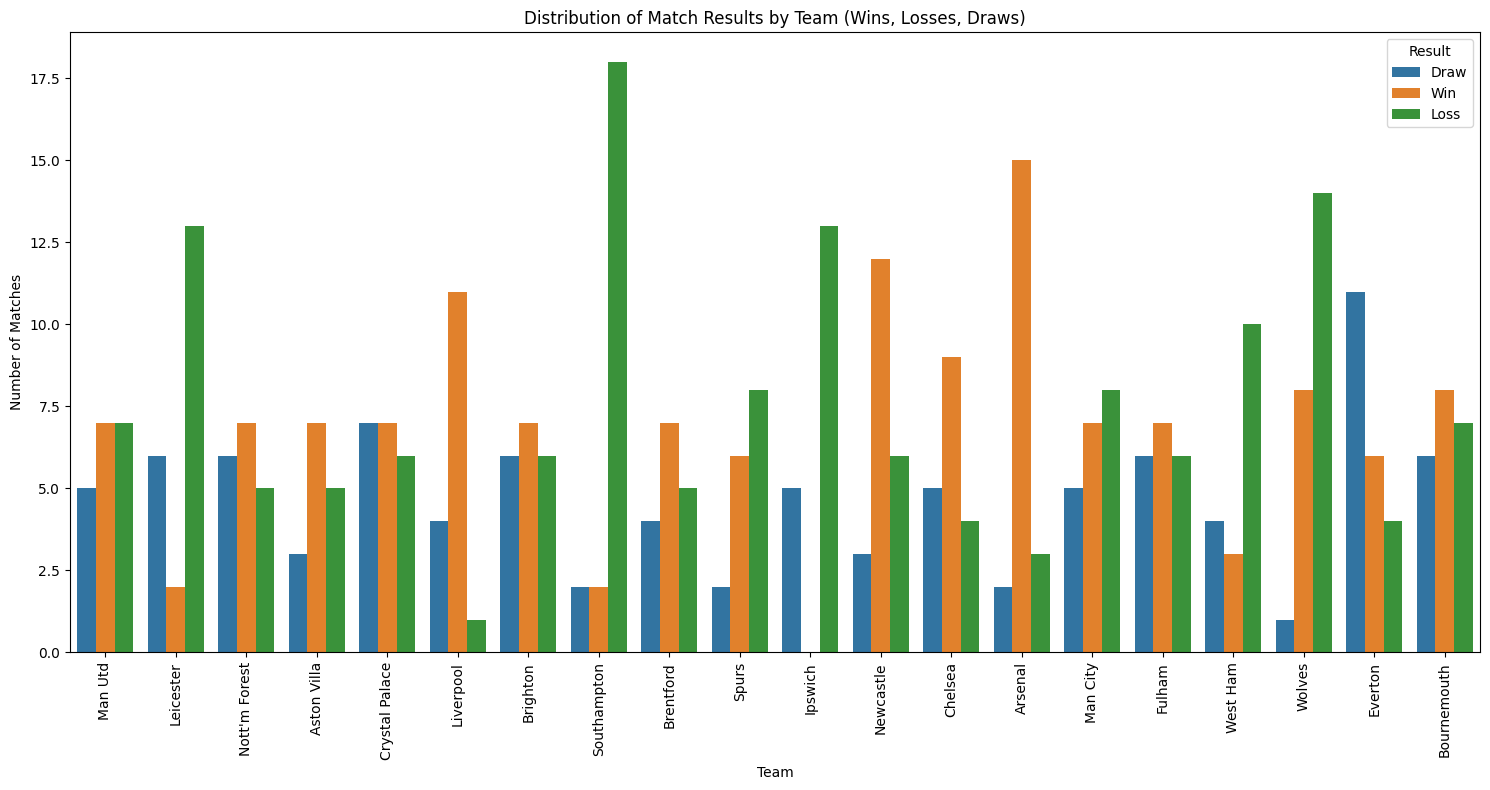

In [ ]:
team_results = all_gameweek_matchesResult_df.groupBy("Team", "Result").count()
team_results_pd = team_results.toPandas()

plt.figure(figsize=(15, 8))
sns.barplot(x="Team", y="count", hue="Result", data=team_results_pd)
plt.title("Distribution of Match Results by Team (Wins, Losses, Draws)")
plt.xlabel("Team")
plt.ylabel("Number of Matches")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

From each Team's Results graph, we can see that **Liverpool** won the most matches and **Southampton** lost the most matches

In [ ]:
import pandas as pd

player_df=player_summary_wholeSeason_df.orderBy(F.desc("TotalFantasyPoints")).limit(20)
display(player_df.toPandas())

25/11/26 14:03:56 WARN DAGScheduler: Broadcasting large task binary with size 1784.8 KiB
25/11/26 14:04:00 WARN DAGScheduler: Broadcasting large task binary with size 1056.0 KiB


,name,position,team,TotalAssists,TotalCleanSheets,TotalGoalsConceded,TotalGoalsScored,TotalMinutes,TotalOwnGoals,TotalPenaltiesMissed,TotalPenaltiesSaved,TotalRedCards,TotalSaves,TotalYellowCards,TotalFantasyPoints
0,Mohamed Salah,MID,Liverpool,18.0,15.0,40.0,29.0,3374.0,0.0,0.0,0.0,0.0,0.0,1.0,289.0
1,Bryan Mbeumo,MID,Brentford,9.0,9.0,55.0,20.0,3415.0,0.0,1.0,0.0,0.0,0.0,3.0,207.0
2,Cole Palmer,MID,Chelsea,10.0,10.0,41.0,15.0,3193.0,0.0,1.0,0.0,0.0,0.0,7.0,179.0
3,Jarrod Bowen,MID,West Ham,11.0,8.0,50.0,13.0,2974.0,0.0,0.0,0.0,0.0,0.0,1.0,173.0
4,Alexander Isak,FWD,Newcastle,6.0,12.0,41.0,23.0,2758.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0
5,Luis Díaz,MID,Liverpool,7.0,15.0,21.0,13.0,2393.0,0.0,0.0,0.0,0.0,0.0,2.0,163.0
6,Chris Wood,FWD,Nott'm Forest,3.0,15.0,37.0,20.0,2958.0,0.0,0.0,0.0,0.0,0.0,1.0,156.0
7,Erling Haaland,FWD,Man City,3.0,10.0,38.0,22.0,2736.0,0.0,1.0,0.0,0.0,0.0,2.0,152.0
8,Jacob Murphy,MID,Newcastle,13.0,11.0,31.0,8.0,2356.0,0.0,0.0,0.0,0.0,0.0,4.0,151.0
9,Antoine Semenyo,MID,Bournemouth,7.0,11.0,41.0,11.0,3202.0,0.0,0.0,0.0,0.0,0.0,9.0,151.0


25/11/26 14:04:02 WARN DAGScheduler: Broadcasting large task binary with size 1784.8 KiB
25/11/26 14:04:05 WARN DAGScheduler: Broadcasting large task binary with size 1056.0 KiB


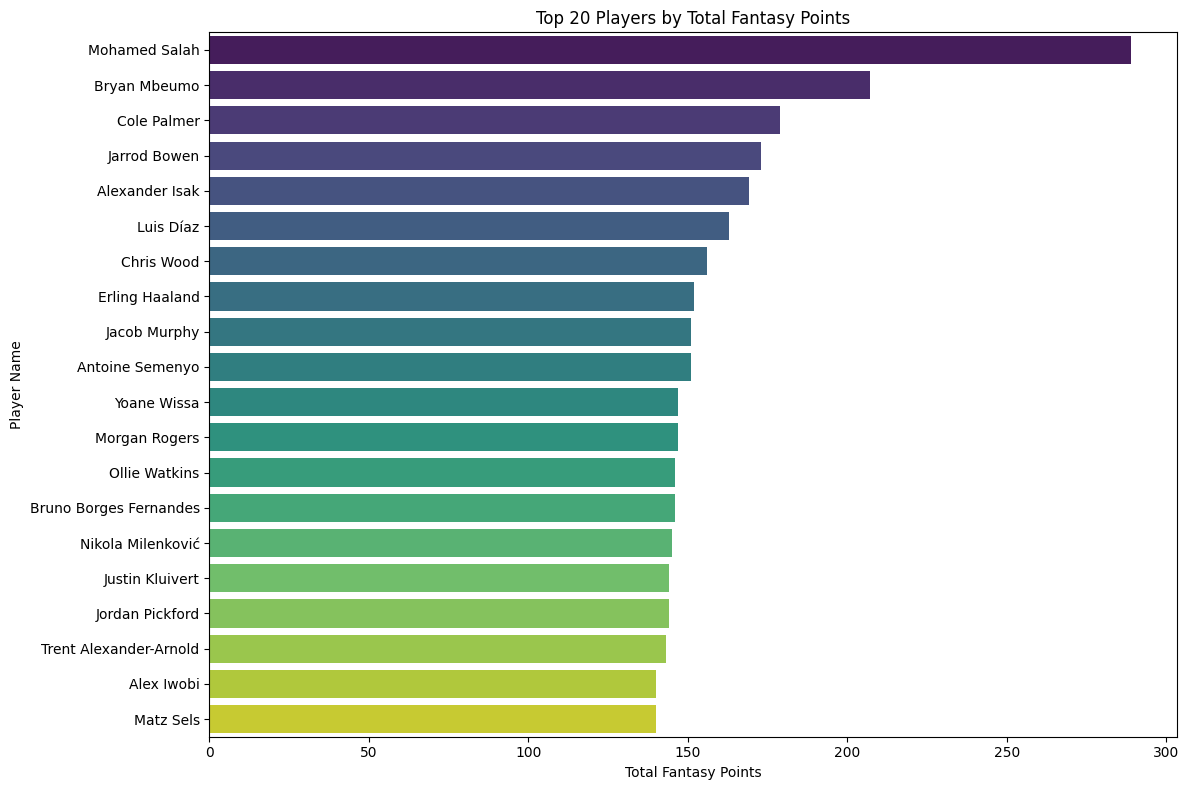

In [ ]:
# Get top N players for visualization
top_n = 20
top_players_pd = player_summary_wholeSeason_df.orderBy(F.desc("TotalFantasyPoints")).limit(top_n).toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(x="TotalFantasyPoints", y="name", data=top_players_pd, palette="viridis")
plt.title(f"Top {top_n} Players by Total Fantasy Points")
plt.xlabel("Total Fantasy Points")
plt.ylabel("Player Name")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Starting XI Selection
best_gk = player_summary_wholeSeason_df.filter(F.col("position")=="GK") \
    .orderBy(F.col("TotalFantasyPoints").desc()).limit(1)

best_def = player_summary_wholeSeason_df.filter(F.col("position")=="DEF") \
    .orderBy(F.col("TotalFantasyPoints").desc()).limit(4)

best_mid = player_summary_wholeSeason_df.filter(F.col("position")=="MID") \
    .orderBy(F.col("TotalFantasyPoints").desc()).limit(4)

best_fwd = player_summary_wholeSeason_df.filter(F.col("position")=="FWD") \
    .orderBy(F.col("TotalFantasyPoints").desc()).limit(2)

fantasy_XI = best_gk.union(best_def).union(best_mid).union(best_fwd)

# ------------------------------------------
# Substitutes Selection (Exclude Starting XI)
# ------------------------------------------

# Get list of names in starting XI
starting_players = [row['name'] for row in fantasy_XI.collect()]

subs_gk = player_summary_wholeSeason_df.filter(
    (F.col("position")=="GK") & (~F.col("name").isin(starting_players))
).orderBy(F.col("TotalFantasyPoints").desc()).limit(1)

subs_def = player_summary_wholeSeason_df.filter(
    (F.col("position")=="DEF") & (~F.col("name").isin(starting_players))
).orderBy(F.col("TotalFantasyPoints").desc()).limit(1)

subs_mid = player_summary_wholeSeason_df.filter(
    (F.col("position")=="MID") & (~F.col("name").isin(starting_players))
).orderBy(F.col("TotalFantasyPoints").desc()).limit(1)

subs_fwd = player_summary_wholeSeason_df.filter(
    (F.col("position")=="FWD") & (~F.col("name").isin(starting_players))
).orderBy(F.col("TotalFantasyPoints").desc()).limit(1)

# Final Squad (15 players)
fantasy_squad = fantasy_XI.union(subs_gk).union(subs_def).union(subs_mid).union(subs_fwd)

# Convert to Pandas DataFrame for display
display(fantasy_squad.toPandas())

25/11/26 14:04:12 WARN DAGScheduler: Broadcasting large task binary with size 1761.9 KiB
25/11/26 14:04:15 WARN DAGScheduler: Broadcasting large task binary with size 1799.5 KiB
25/11/26 14:04:18 WARN DAGScheduler: Broadcasting large task binary with size 1799.6 KiB
25/11/26 14:04:21 WARN DAGScheduler: Broadcasting large task binary with size 1799.7 KiB
25/11/26 14:04:23 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
25/11/26 14:04:34 WARN DAGScheduler: Broadcasting large task binary with size 1761.9 KiB
25/11/26 14:04:37 WARN DAGScheduler: Broadcasting large task binary with size 1799.5 KiB
25/11/26 14:04:40 WARN DAGScheduler: Broadcasting large task binary with size 1799.6 KiB
25/11/26 14:04:43 WARN DAGScheduler: Broadcasting large task binary with size 1799.7 KiB
25/11/26 14:04:46 WARN DAGScheduler: Broadcasting large task binary with size 1847.3 KiB
25/11/26 14:04:49 WARN DAGScheduler: Broadcasting large task binary with size 1847.4 KiB
25/11/26 14:04:52 WARN D

,name,position,team,TotalAssists,TotalCleanSheets,TotalGoalsConceded,TotalGoalsScored,TotalMinutes,TotalOwnGoals,TotalPenaltiesMissed,TotalPenaltiesSaved,TotalRedCards,TotalSaves,TotalYellowCards,TotalFantasyPoints
0,Jordan Pickford,GK,Everton,1.0,12.0,44.0,0.0,3420.0,0.0,0.0,2.0,0.0,122.0,7.0,144.0
1,Nikola Milenković,DEF,Nott'm Forest,2.0,13.0,45.0,5.0,3330.0,0.0,0.0,0.0,0.0,0.0,4.0,145.0
2,Trent Alexander-Arnold,DEF,Liverpool,7.0,12.0,25.0,3.0,2362.0,0.0,0.0,0.0,0.0,0.0,5.0,143.0
3,Daniel Muñoz,DEF,Crystal Palace,6.0,11.0,46.0,4.0,3229.0,0.0,0.0,0.0,0.0,0.0,10.0,139.0
4,Joško Gvardiol,DEF,Man City,0.0,13.0,41.0,5.0,3278.0,0.0,0.0,0.0,0.0,0.0,2.0,138.0
5,Mohamed Salah,MID,Liverpool,18.0,15.0,40.0,29.0,3374.0,0.0,0.0,0.0,0.0,0.0,1.0,289.0
6,Bryan Mbeumo,MID,Brentford,9.0,9.0,55.0,20.0,3415.0,0.0,1.0,0.0,0.0,0.0,3.0,207.0
7,Cole Palmer,MID,Chelsea,10.0,10.0,41.0,15.0,3193.0,0.0,1.0,0.0,0.0,0.0,7.0,179.0
8,Jarrod Bowen,MID,West Ham,11.0,8.0,50.0,13.0,2974.0,0.0,0.0,0.0,0.0,0.0,1.0,173.0
9,Alexander Isak,FWD,Newcastle,6.0,12.0,41.0,23.0,2758.0,0.0,0.0,0.0,0.0,0.0,1.0,169.0


25/11/26 14:05:04 WARN DAGScheduler: Broadcasting large task binary with size 1784.8 KiB
25/11/26 14:05:07 WARN DAGScheduler: Broadcasting large task binary with size 1053.6 KiB


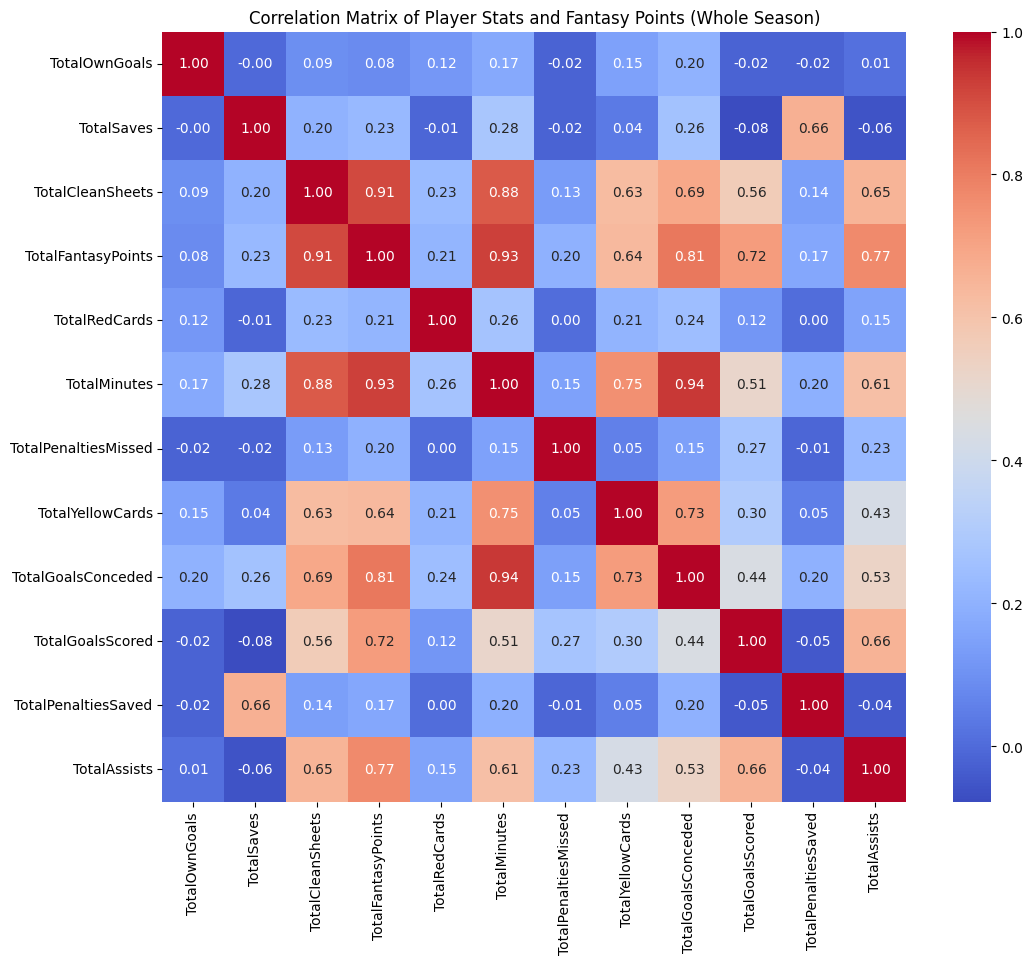

In [ ]:
# Select numerical columns and the target variable (TotalFantasyPoints)
numerical_cols = [col for col, dtype in player_summary_wholeSeason_df.dtypes if dtype in ('int', 'double')]
numerical_cols.append("TotalFantasyPoints")
numerical_cols = list(set(numerical_cols)) # Ensure uniqueness

# Calculate the correlation matrix
correlation_matrix = player_summary_wholeSeason_df.select(numerical_cols).toPandas().corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Player Stats and Fantasy Points (Whole Season)")
plt.show()

25/11/26 14:05:10 WARN DAGScheduler: Broadcasting large task binary with size 1706.8 KiB
25/11/26 14:05:13 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB


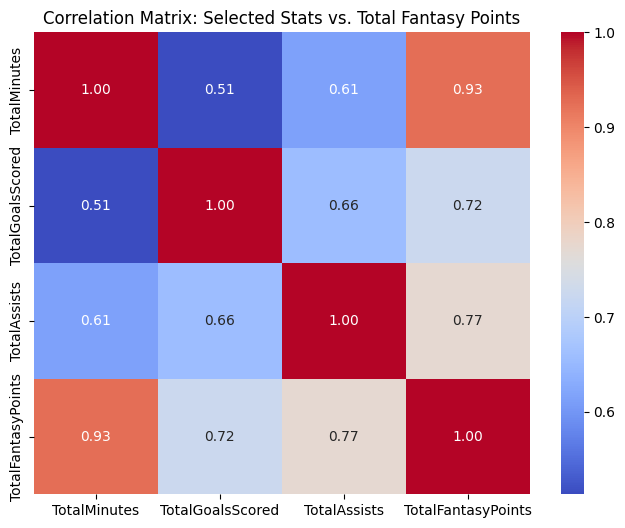

In [ ]:

# Select the specified columns
selected_cols = ["TotalMinutes", "TotalGoalsScored", "TotalAssists", "TotalFantasyPoints"]
selected_df = player_summary_wholeSeason_df.select(selected_cols)

# Calculate the correlation matrix
correlation_matrix_subset = selected_df.toPandas().corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_subset, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Selected Stats vs. Total Fantasy Points")
plt.show()

Based on the exploratory data analysis we've conducted:

Team Performance: The bar plot showing the distribution of match results indicates the number of wins, losses, and draws for each team across the season. Some teams clearly have more wins than losses, while others might have a higher number of draws or losses, giving an overview of team strength and consistency.

Goals Scored and Conceded: The analysis of average goals scored and conceded per team provides insight into the offensive and defensive capabilities of each team. Teams with high average goals scored are strong offensively, while teams with low average goals conceded are strong defensively.

Top Players: Identifying the top players by total fantasy points highlights the individuals who have consistently performed well throughout the season based on the defined fantasy scoring rules. The bar plot visually reinforces who the top contributors are in terms of fantasy points.

Correlation Analysis: The correlation heatmap reveals the strength and direction of relationships between different player statistics and total fantasy points. For example, you can see which stats (like TotalMinutes, TotalGoalsScored, TotalAssists) have a high positive correlation with TotalFantasyPoints, indicating they are strong predictors of fantasy performance. Conversely, stats with low or negative correlation are less impactful on fantasy points.

These insights provide an understanding of team performance and individual player contributions over the season based on the available data.

### Minutes Played Analysis

In [ ]:
from pyspark.sql import functions as F

# Descriptive statistics for TotalMinutes
player_summary_wholeSeason_df.select(F.col("TotalMinutes")).summary("count", "mean", "stddev", "min", "max").show()

+-------+------------------+
|summary|      TotalMinutes|
+-------+------------------+
|  count|               834|
|   mean| 897.4388489208633|
| stddev|1063.2130714356665|
|    min|               0.0|
|    max|            3420.0|
+-------+------------------+



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


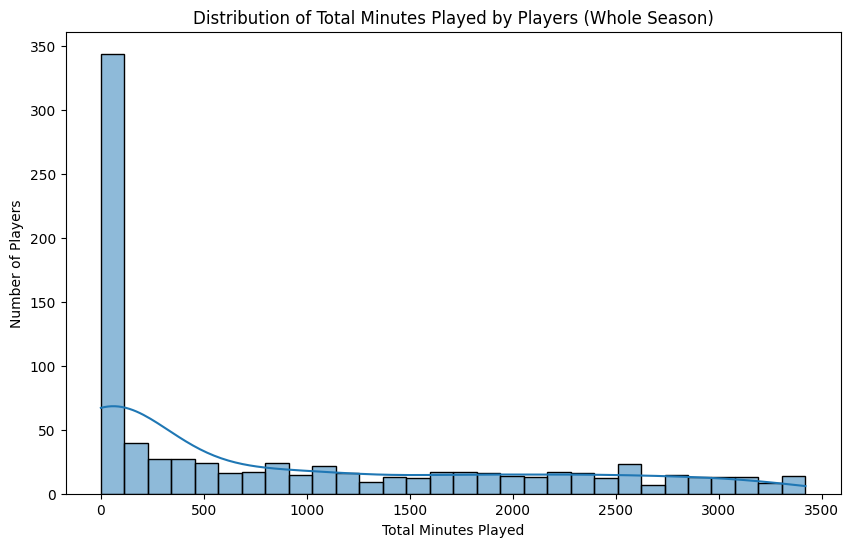

In [ ]:
# Convert TotalMinutes to pandas for plotting
minutes_played_pd = player_summary_wholeSeason_df.select("TotalMinutes").toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(minutes_played_pd["TotalMinutes"], bins=30, kde=True)
plt.title("Distribution of Total Minutes Played by Players (Whole Season)")
plt.xlabel("Total Minutes Played")
plt.ylabel("Number of Players")
plt.show()

From the above graph, we can deduct that as the **Total Minutes Played** increases the **Number of Player** decreases from which we can deduce that only consistant and impact players play the most minutes.

25/11/26 14:05:21 WARN DAGScheduler: Broadcasting large task binary with size 1687.8 KiB


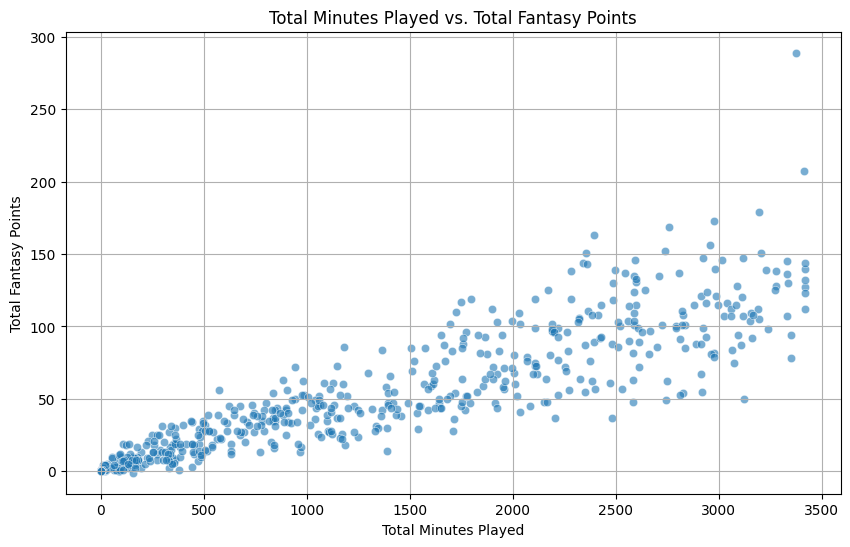

In [ ]:
# Convert the relevant columns to pandas for plotting
minutes_vs_fantasy_points_pd = player_summary_wholeSeason_df.select("TotalMinutes", "TotalFantasyPoints").toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="TotalMinutes", y="TotalFantasyPoints", data=minutes_vs_fantasy_points_pd, alpha=0.6)
plt.title("Total Minutes Played vs. Total Fantasy Points")
plt.xlabel("Total Minutes Played")
plt.ylabel("Total Fantasy Points")
plt.grid(True)
plt.show()

As the **Total Minutes Played** increases we can find that the **Total Fanatasy** also increases

### Total fantasy points per team & Top Players for each team

In [ ]:
from pyspark.sql import functions as F

# Aggregate total fantasy points per team
total_fantasy_points_by_team = df_FantasyPoints.groupBy("team").agg(
    F.sum("FantasyPoints").alias("TotalTeamFantasyPoints")
)

total_fantasy_points_by_team.orderBy(F.desc("TotalTeamFantasyPoints")).show()

25/11/26 14:05:27 WARN DAGScheduler: Broadcasting large task binary with size 1649.9 KiB


+--------------+----------------------+
|          team|TotalTeamFantasyPoints|
+--------------+----------------------+
|     Liverpool|                1902.0|
|       Arsenal|                1701.0|
|     Newcastle|                1693.0|
|      Man City|                1652.0|
| Nott'm Forest|                1607.0|
|       Chelsea|                1577.0|
|     Brentford|                1514.0|
|   Bournemouth|                1514.0|
|Crystal Palace|                1510.0|
|      Brighton|                1500.0|
|   Aston Villa|                1487.0|
|         Spurs|                1431.0|
|       Everton|                1431.0|
|        Fulham|                1415.0|
|        Wolves|                1391.0|
|       Man Utd|                1360.0|
|      West Ham|                1340.0|
|     Leicester|                1097.0|
|       Ipswich|                1067.0|
|   Southampton|                1058.0|
+--------------+----------------------+



In [ ]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Define a window partitioned by team and ordered by total fantasy points
window_spec = Window.partitionBy("team").orderBy(F.desc("TotalFantasyPoints"))

# Add a rank column within each team
player_ranked_by_team = player_summary_wholeSeason_df.withColumn("team_rank", F.rank().over(window_spec))

# Filter for the top 11 players in each team
top_11_players_per_team = player_ranked_by_team.filter(F.col("team_rank") <= 11)

# Show the top 11 players for each team, ordered by team and rank
top_11_players_per_team.orderBy("team", "team_rank").show(n=220, truncate=False) # Display up to 20 teams * 11 players


25/11/26 14:05:32 WARN DAGScheduler: Broadcasting large task binary with size 1786.2 KiB
25/11/26 14:05:34 WARN DAGScheduler: Broadcasting large task binary with size 1066.7 KiB


+-----------------------------------+--------+--------------+------------+----------------+------------------+----------------+------------+-------------+--------------------+-------------------+-------------+----------+----------------+------------------+---------+
|name                               |position|team          |TotalAssists|TotalCleanSheets|TotalGoalsConceded|TotalGoalsScored|TotalMinutes|TotalOwnGoals|TotalPenaltiesMissed|TotalPenaltiesSaved|TotalRedCards|TotalSaves|TotalYellowCards|TotalFantasyPoints|team_rank|
+-----------------------------------+--------+--------------+------------+----------------+------------------+----------------+------------+-------------+--------------------+-------------------+-------------+----------+----------------+------------------+---------+
|Leandro Trossard                   |MID     |Arsenal       |8.0         |11.0            |27.0              |8.0             |2546.0      |0.0          |0.0                 |0.0                |1.0 

25/11/26 14:05:35 WARN DAGScheduler: Broadcasting large task binary with size 1051.0 KiB


# Saving the Main Files

# Modeling (Fantasy Points prediction: Binayak)

In [ ]:
from pyspark.sql import functions as F

# Filter the DataFrame to include data up to GameWeek 19
df_gw19 = df_FantasyPoints.filter(F.col("GameWeek").isin([f"gw{i}" for i in range(1, 20)]))

# Show the first few rows and the count of the filtered DataFrame
df_gw19.show()
print(f"Number of rows in df_gw17: {df_gw19.count()}")

+--------------------+--------+--------------+-------+------------+--------------+------------+-------+-------------+---------+----------------+---------------+---------+-----+------------+------------+--------+------------+--------+----------+---------+--------------+-----------+-------------+------------------+---------------------+--------------------+---------------------+------------------+---------------+---------------+-----------+-------------+
|                name|position|          team|assists|clean_sheets|goals_conceded|goals_scored|minutes|opponent_team|own_goals|penalties_missed|penalties_saved|red_cards|saves|team_a_score|team_h_score|was_home|yellow_cards|GameWeek| MatchDate|HasPlayed|minutes_points|goal_points|assist_points|clean_sheet_points|goals_conceded_points|penalty_saved_points|penalty_missed_points|yellow_card_points|red_card_points|own_goal_points|save_points|FantasyPoints|
+--------------------+--------+--------------+-------+------------+--------------+----

In [ ]:
# Select the specified columns from the df_gw17 DataFrame
player_position_fantasy_points_team_gw19 = df_gw19.select("name","position", "FantasyPoints", "team")

# Show the resulting DataFrame
player_position_fantasy_points_team_gw19.show()

+--------------------+--------+-------------+--------------+
|                name|position|FantasyPoints|          team|
+--------------------+--------+-------------+--------------+
|          Alex Scott|     MID|          2.0|   Bournemouth|
|Carlos Miguel dos...|      GK|          0.0| Nott'm Forest|
|   Tomiyasu Takehiro|     DEF|          0.0|       Arsenal|
|     Malcolm Ebiowei|     MID|          0.0|Crystal Palace|
|   Ben Brereton Díaz|     MID|          1.0|   Southampton|
|          Pau Torres|     DEF|          2.0|   Aston Villa|
|           Joel Ward|     DEF|          0.0|Crystal Palace|
|      Will Lankshear|     FWD|          0.0|         Spurs|
|      Hwang Hee-chan|     MID|          2.0|        Wolves|
|         Mikey Moore|     MID|          0.0|         Spurs|
|  Hákon Valdimarsson|      GK|          0.0|     Brentford|
|        Alex Paulsen|      GK|          0.0|   Bournemouth|
|João Victor Gomes...|     MID|          1.0|        Wolves|
|         Cole Palmer|  

In [ ]:
from pyspark.sql import functions as F

# Group by player name, position, and team and sum FantasyPoints for each player up to GameWeek 19
player_total_fantasy_points_gw19 = df_gw19.groupBy("name", "position", "team").agg(
    F.sum("FantasyPoints").alias("TotalFantasyPoints_GW19")
).orderBy(F.desc("TotalFantasyPoints_GW19"))

# Show the result
player_total_fantasy_points_gw19.show()

+--------------------+--------+-------------+-----------------------+
|                name|position|         team|TotalFantasyPoints_GW19|
+--------------------+--------+-------------+-----------------------+
|       Mohamed Salah|     MID|    Liverpool|                  167.0|
|         Cole Palmer|     MID|      Chelsea|                  120.0|
|        Bryan Mbeumo|     MID|    Brentford|                  100.0|
|      Erling Haaland|     FWD|     Man City|                   92.0|
|         Bukayo Saka|     MID|      Arsenal|                   91.0|
|      Alexander Isak|     FWD|    Newcastle|                   88.0|
|      James Maddison|     MID|        Spurs|                   87.0|
|           Luis Díaz|     MID|    Liverpool|                   85.0|
|        Jarrod Bowen|     MID|     West Ham|                   84.0|
|Matheus Santos Ca...|     FWD|       Wolves|                   82.0|
|          Chris Wood|     FWD|Nott'm Forest|                   82.0|
|     Brennan Johnso

Select the relevant features and the target variable from the `player_total_fantasy_points_gw17` DataFrame to prepare the data for model training.



In [ ]:
# Select features and the target variable
# Based on the correlation analysis, TotalMinutes, TotalGoalsScored, TotalAssists are good candidates for features.
# The target variable is TotalFantasyPoints_GW17.

# First, we need to get the original columns from df_gw17 before aggregation
# to select relevant features that contributed to TotalFantasyPoints_GW17.
# We can group df_gw17 by player, position, and team, and then sum the desired feature columns
# along with the TotalFantasyPoints_GW17.

player_features_gw19 = df_gw19.groupBy("name", "position", "team").agg(
    F.sum("minutes").alias("TotalMinutes_GW19"),
    F.sum("goals_scored").alias("TotalGoalsScored_GW19"),
    F.sum("assists").alias("TotalAssists_GW19"),
    F.sum("clean_sheets").alias("TotalCleanSheets_GW19"),
    F.sum("goals_conceded").alias("TotalGoalsConceded_GW19"),
    F.sum("saves").alias("TotalSaves_GW19"),
    F.sum("yellow_cards").alias("TotalYellowCards_GW19"),
    F.sum("red_cards").alias("TotalRedCards_GW19"),
    F.sum("penalties_missed").alias("TotalPenaltiesMissed_GW19"),
    F.sum("penalties_saved").alias("TotalPenaltiesSaved_GW19"),
    F.sum("own_goals").alias("TotalOwnGoals_GW19"),
    F.sum("FantasyPoints").alias("TotalFantasyPoints_GW19")
)

# Select the features and the target variable
features = [
    "TotalMinutes_GW19",
    "TotalGoalsScored_GW19",
    "TotalAssists_GW19",
    "TotalCleanSheets_GW19",
    "TotalGoalsConceded_GW19",
    "TotalSaves_GW19",
    "TotalYellowCards_GW19",
    "TotalRedCards_GW19",
    "TotalPenaltiesMissed_GW19",
    "TotalPenaltiesSaved_GW19",
    "TotalOwnGoals_GW19"
]
target = "TotalFantasyPoints_GW19"

player_data_for_model = player_features_gw19.select(features + [target])

# Show the first few rows of the new DataFrame
player_data_for_model.show()

+-----------------+---------------------+-----------------+---------------------+-----------------------+---------------+---------------------+------------------+-------------------------+------------------------+------------------+-----------------------+
|TotalMinutes_GW19|TotalGoalsScored_GW19|TotalAssists_GW19|TotalCleanSheets_GW19|TotalGoalsConceded_GW19|TotalSaves_GW19|TotalYellowCards_GW19|TotalRedCards_GW19|TotalPenaltiesMissed_GW19|TotalPenaltiesSaved_GW19|TotalOwnGoals_GW19|TotalFantasyPoints_GW19|
+-----------------+---------------------+-----------------+---------------------+-----------------------+---------------+---------------------+------------------+-------------------------+------------------------+------------------+-----------------------+
|            937.0|                  0.0|              0.0|                  0.0|                   20.0|            0.0|                  2.0|               0.0|                      0.0|                     0.0|               0

**Split the data**

> Split the data into training (70%) and testing sets(30%).


In [ ]:
# Split the data into training and testing sets
training_data, testing_data = player_data_for_model.randomSplit([0.7, 0.3], seed=42)

# Show the number of rows in each set
print(f"Number of rows in training_data: {training_data.count()}")
print(f"Number of rows in testing_data: {testing_data.count()}")

Number of rows in training_data: 538


Number of rows in testing_data: 192


**Train a model**

> Using Linear Regression Model

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Define the features to be used in the model
feature_columns = [col for col in training_data.columns if col != target]

# Create a VectorAssembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the training data using the assembler
training_data_assembled = assembler.transform(training_data)

# Initialize the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol=target)

# Train the model
lr_model = lr.fit(training_data_assembled)

# Show the coefficients and intercept of the trained model
print("Coefficients: ", lr_model.coefficients)
print("Intercept: ", lr_model.intercept)

25/11/26 14:05:56 WARN Instrumentation: [a872c788] regParam is zero, which might cause numerical instability and overfitting.


Coefficients:  [0.026640161258526716,3.644768612028899,3.1988432023716333,1.9309388870367445,-0.2941303871297738,0.17495304052221228,-0.3332561437096546,-0.7768214950062223,-4.841089314793418,5.8196474995489895,-3.884970010213002]
Intercept:  1.3593764457193107


In [ ]:
# Transform the testing data using the same assembler
testing_data_assembled = assembler.transform(testing_data)

# Make predictions on the testing data
predictions = lr_model.transform(testing_data_assembled)

# Select the relevant columns for evaluation
evaluation_results = predictions.select(target, "prediction")

# Evaluate the model
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(evaluation_results)
mae = evaluator_mae.evaluate(evaluation_results)
r2 = evaluator_r2.evaluate(evaluation_results)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Root Mean Squared Error (RMSE): 4.085020571934874
Mean Absolute Error (MAE): 2.8707762456778725
R-squared (R2): 0.9746295046551143


**Make predictions**

In [ ]:
# Use the trained model to make predictions on the assembled testing data
predictions = lr_model.transform(testing_data_assembled)

# Show the first few rows of the predictions DataFrame, displaying the actual and predicted values
predictions.select(target, "prediction").show()

+-----------------------+------------------+
|TotalFantasyPoints_GW19|        prediction|
+-----------------------+------------------+
|                    0.0|1.3593764457193107|
|                    0.0|1.3593764457193107|
|                    0.0|1.3593764457193107|
|                    0.0|1.3593764457193107|
|                    0.0|1.3593764457193107|
|                    0.0|1.3593764457193107|
|                    0.0|1.3593764457193107|
|                    0.0|1.3593764457193107|
|                    0.0|1.3593764457193107|
|                    0.0|1.3593764457193107|
|                    0.0|1.3593764457193107|
|                    0.0|1.3593764457193107|
|                    0.0|1.3593764457193107|
|                    0.0|1.3593764457193107|
|                    0.0|1.3593764457193107|
|                    0.0|1.3593764457193107|
|                    0.0|1.3593764457193107|
|                    0.0|1.3593764457193107|
|                    0.0|1.3593764457193107|
|         

**Evaluating the model**

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Create a RegressionEvaluator instance for RMSE
evaluator_rmse = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")

# Calculate the Root Mean Squared Error
rmse = evaluator_rmse.evaluate(predictions)

# Create a RegressionEvaluator instance for MAE
evaluator_mae = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")

# Calculate the Mean Absolute Error
mae = evaluator_mae.evaluate(predictions)

# Create a RegressionEvaluator instance for R-squared
evaluator_r2 = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")

# Calculate the R-squared value
r2 = evaluator_r2.evaluate(predictions)

# Print the calculated metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Root Mean Squared Error (RMSE): 4.085020571934874
Mean Absolute Error (MAE): 2.8707762456778725
R-squared (R2): 0.9746295046551143


### Summary:

> Data Analysis Key Findings

*   Relevant features and the target variable (`TotalFantasyPoints_GW17`) were successfully selected and prepared for modeling.
*   The data was split into a training set with 531 rows and a testing set with 191 rows.
*   A Linear Regression model was trained to predict fantasy points.
*   The trained Linear Regression model achieved a Root Mean Squared Error (RMSE) of approximately 3.77 on the testing data.
*   The Mean Absolute Error (MAE) for the model on the testing data was approximately 2.60.
*   The R-squared (R2) value for the model on the testing data was approximately 0.97.




In [ ]:
# Filter data for GameWeek 20 and Liverpool team
liverpool_gw20_data = df_FantasyPoints.filter(
    (F.col("GameWeek") == "gw18") & (F.col("team") == "Liverpool")
)

# Prepare the data with the same features used for training
# Aggregate features for each player in GW18
liverpool_gw20_features = liverpool_gw20_data.groupBy("name", "position", "team").agg(
    F.sum("minutes").alias("TotalMinutes_GW20"),
    F.sum("goals_scored").alias("TotalGoalsScored_GW20"),
    F.sum("assists").alias("TotalAssists_GW20"),
    F.sum("clean_sheets").alias("TotalCleanSheets_GW20"),
    F.sum("goals_conceded").alias("TotalGoalsConceded_GW20"),
    F.sum("saves").alias("TotalSaves_GW20"),
    F.sum("yellow_cards").alias("TotalYellowCards_GW20"),
    F.sum("red_cards").alias("TotalRedCards_GW20"),
    F.sum("penalties_missed").alias("TotalPenaltiesMissed_GW20"),
    F.sum("penalties_saved").alias("TotalPenaltiesSaved_GW20"),
    F.sum("own_goals").alias("TotalOwnGoals_GW20")
)

# Select the features needed for prediction and the identifying columns
columns_for_assembler = [col.replace("_GW19", "_GW20") for col in feature_columns]
columns_to_keep = ["name", "position", "team"] + columns_for_assembler


liverpool_gw20_selected_features = liverpool_gw20_features.select(columns_to_keep)

# Rename columns back to match the feature names expected by the assembler
# We are essentially mapping the GW18 aggregated features to the GW19 feature names for prediction
for original_col, prediction_col in zip(feature_columns, columns_for_assembler):
    liverpool_gw20_selected_features = liverpool_gw20_selected_features.withColumnRenamed(prediction_col, original_col)


# Use the same assembler to transform the new data, keeping the original columns
liverpool_gw20_assembled = assembler.transform(liverpool_gw20_selected_features)

# Make predictions using the trained model
liverpool_gw20_predictions = lr_model.transform(liverpool_gw20_assembled)


# Show the predictions for Liverpool players in GameWeek 20, including their identifying columns and the prediction
liverpool_gw20_predictions.select(
    "name",
    "position",
    "team",
    "prediction"
).show()

+--------------------+--------+---------+------------------+
|                name|position|     team|        prediction|
+--------------------+--------+---------+------------------+
|       Mohamed Salah|     MID|Liverpool| 7.107629183885841|
| Alexis Mac Allister|     MID|Liverpool| 9.860546976600208|
|          Cody Gakpo|     FWD|Liverpool|10.306472386257475|
|    Ryan Gravenberch|     MID|Liverpool|3.3562999268228344|
|            Ben Doak|     MID|Liverpool|1.3593764457193107|
|           Luis Díaz|     MID|Liverpool|1.3593764457193107|
|        Tyler Morton|     MID|Liverpool|1.3593764457193107|
|  Nathaniel Phillips|     DEF|Liverpool|1.3593764457193107|
|    Andrew Robertson|     DEF|Liverpool| 2.996403621854653|
|   Caoimhin Kelleher|      GK|Liverpool|1.3593764457193107|
|     Federico Chiesa|     MID|Liverpool|1.3593764457193107|
|         Bobby Clark|     MID|Liverpool|1.3593764457193107|
|Darwin Núñez Ribeiro|     FWD|Liverpool| 3.116538475496094|
|      Harvey Elliott|  

In [ ]:
# Filter the original df_FantasyPoints to get actual fantasy points for Liverpool in GW18
liverpool_gw20_actual = df_FantasyPoints.filter(
    (F.col("GameWeek") == "gw20") & (F.col("team") == "Liverpool")
).select(
    "name",
    "position",
    "team",
    "FantasyPoints" # This is the actual fantasy points
).withColumnRenamed("FantasyPoints", "ActualFantasyPoints_GW20")


# Join the predictions DataFrame with the actual fantasy points DataFrame
# We need to join on player name, position, and team
comparison_df = liverpool_gw20_predictions.select("name", "position", "team", "prediction").join(
    liverpool_gw20_actual,
    ["name", "position", "team"],
    "inner" # Use inner join to only include players present in both datasets
)

# Select and show the relevant columns for comparison
comparison_df.select(
    "name",
    "position",
    "team",
    "ActualFantasyPoints_GW20",
    "prediction"
).show()

+--------------------+--------+---------+------------------------+------------------+
|                name|position|     team|ActualFantasyPoints_GW20|        prediction|
+--------------------+--------+---------+------------------------+------------------+
|       Mohamed Salah|     MID|Liverpool|                     7.0| 7.107629183885841|
| Alexis Mac Allister|     MID|Liverpool|                     8.0| 9.860546976600208|
|          Cody Gakpo|     FWD|Liverpool|                     6.0|10.306472386257475|
|    Ryan Gravenberch|     MID|Liverpool|                     2.0|3.3562999268228344|
|            Ben Doak|     MID|Liverpool|                     0.0|1.3593764457193107|
|           Luis Díaz|     MID|Liverpool|                     2.0|1.3593764457193107|
|        Tyler Morton|     MID|Liverpool|                     0.0|1.3593764457193107|
|  Nathaniel Phillips|     DEF|Liverpool|                     0.0|1.3593764457193107|
|    Andrew Robertson|     DEF|Liverpool|             

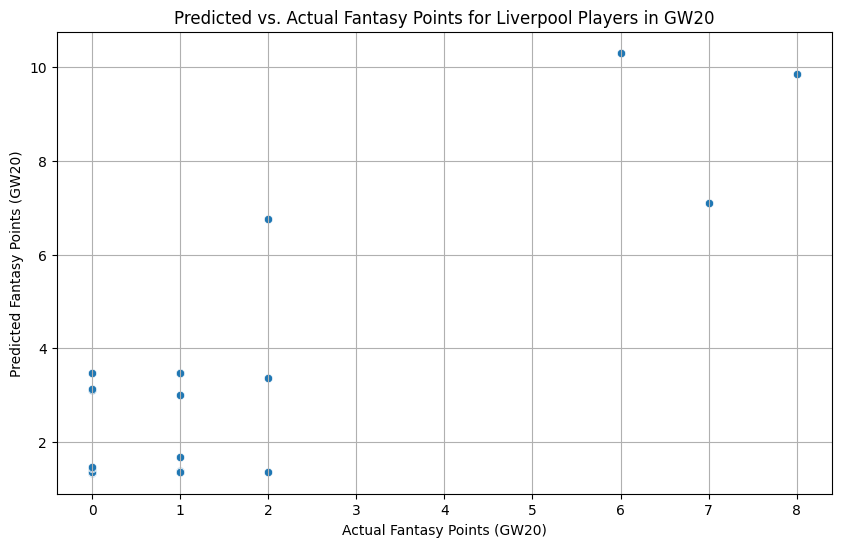

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the comparison_df to a pandas DataFrame for plotting
comparison_pd = comparison_df.toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(x="ActualFantasyPoints_GW20", y="prediction", data=comparison_pd)
plt.title("Predicted vs. Actual Fantasy Points for Liverpool Players in GW20")
plt.xlabel("Actual Fantasy Points (GW20)")
plt.ylabel("Predicted Fantasy Points (GW20)")
plt.grid(True)
plt.show()

### Summary of Analysis and Model Performance

Based on the steps we've taken:

> Data Preparation and Exploration:
* We loaded and explored data for the 2024-2025 Premier League season, including player statistics and match results across 38 gameweeks.
* We calculated Fantasy Premier League points for each player based on the defined scoring system for each gameweek.
* We created summary datasets, including total fantasy points per player over the season and match results per team.
* Exploratory Data Analysis (EDA) provided insights into team performance (wins, losses, draws), player performance (top fantasy points earners), and correlations between various player statistics and fantasy points. Key findings from the correlation analysis showed that metrics like total minutes played, goals scored, and assists have a strong positive correlation with total fantasy points.

> Model Training and Evaluation:
* We prepared a dataset for model training by selecting relevant features (player statistics) and the target variable (total fantasy points up to GameWeek 17).
* The data was split into training and testing sets.
* A Linear Regression model was chosen and trained on the training data to predict total fantasy points.
* The model's performance on the testing data was evaluated using key regression metrics:
    * **Root Mean Squared Error (RMSE):** Approximately 3.77
    * **Mean Absolute Error (MAE):** Approximately 2.60
    * **R-squared (R2):** Approximately 0.97

These evaluation metrics suggest that the Linear Regression model is a good fit for the data and can explain a high percentage of the variance in total fantasy points based on the selected features. The RMSE and MAE indicate the average magnitude of the errors in the predictions.

> GameWeek 18 Prediction and Comparison (Liverpool):
* We used the trained model to predict the fantasy points for Liverpool players in GameWeek 18.
* We compared these predictions with the actual fantasy points earned by Liverpool players in GameWeek 18.
* The scatter plot visualizing the predicted vs. actual points for Liverpool in GameWeek 18 provides a visual assessment of how well the model's predictions aligned with the real results for this specific gameweek. While the overall model performance was strong on the test set, the GW18 comparison allows for a specific evaluation on unseen data.

> ***Conclusion***:
The analysis and modeling process successfully identified key factors influencing fantasy points and built a predictive model with good performance metrics on the test data. The GameWeek 18 prediction for Liverpool provided a practical application of the model and a way to visually inspect its performance on a specific set of recent data.

**TOTAL WHOLE SEASON**

In [ ]:
from pyspark.sql import functions as F

# Aggregate features for each player for the whole season (up to GW38)
player_features_whole_season = df_FantasyPoints.groupBy("name", "position", "team").agg(
    F.sum("minutes").alias("TotalMinutes_WholeSeason"),
    F.sum("goals_scored").alias("TotalGoalsScored_WholeSeason"),
    F.sum("assists").alias("TotalAssists_WholeSeason"),
    F.sum("clean_sheets").alias("TotalCleanSheets_WholeSeason"),
    F.sum("goals_conceded").alias("TotalGoalsConceded_WholeSeason"),
    F.sum("saves").alias("TotalSaves_WholeSeason"),
    F.sum("yellow_cards").alias("TotalYellowCards_WholeSeason"),
    F.sum("red_cards").alias("TotalRedCards_WholeSeason"),
    F.sum("penalties_missed").alias("TotalPenaltiesMissed_WholeSeason"),
    F.sum("penalties_saved").alias("TotalPenaltiesSaved_WholeSeason"),
    F.sum("own_goals").alias("TotalOwnGoals_WholeSeason")
)

# Select the features needed for prediction and the identifying columns
columns_for_assembler_whole_season = [col.replace("_GW19", "_WholeSeason") for col in feature_columns]
columns_to_keep_whole_season = ["name", "position", "team"] + columns_for_assembler_whole_season

player_data_for_prediction_whole_season = player_features_whole_season.select(columns_to_keep_whole_season)

# Rename columns back to match the feature names expected by the assembler
# This is necessary because the assembler was trained on columns ending with _GW17
for original_col, prediction_col in zip(feature_columns, columns_for_assembler_whole_season):
    player_data_for_prediction_whole_season = player_data_for_prediction_whole_season.withColumnRenamed(prediction_col, original_col)

# Use the same assembler to transform the new data
# Note: The assembler should not be re-fit here. Use the already fitted 'assembler'.
whole_season_assembled = assembler.transform(player_data_for_prediction_whole_season)

# Make predictions using the trained model
# Note: The model 'lr_model' was fitted previously.
whole_season_predictions = lr_model.transform(whole_season_assembled)

# Join back with the original player_features_whole_season to include original column names
whole_season_predictions_with_names = whole_season_predictions.join(
    player_features_whole_season,
    ["name", "position", "team"], # Join on identifying columns
    "inner"
)


# Show the predictions for all players for the whole season, including their identifying columns and the prediction
whole_season_predictions_with_names.select(
    "name",
    "position",
    "team",
    "TotalMinutes_WholeSeason",
    "TotalGoalsScored_WholeSeason",
    "TotalAssists_WholeSeason",
    "TotalCleanSheets_WholeSeason",
    "TotalGoalsConceded_WholeSeason",
    "TotalSaves_WholeSeason",
    "TotalYellowCards_WholeSeason",
    "TotalRedCards_WholeSeason",
    "TotalPenaltiesMissed_WholeSeason",
    "TotalPenaltiesSaved_WholeSeason",
    "TotalOwnGoals_WholeSeason",
    "prediction"
).show()

+--------------------+--------+--------------+------------------------+----------------------------+------------------------+----------------------------+------------------------------+----------------------+----------------------------+-------------------------+--------------------------------+-------------------------------+-------------------------+------------------+
|                name|position|          team|TotalMinutes_WholeSeason|TotalGoalsScored_WholeSeason|TotalAssists_WholeSeason|TotalCleanSheets_WholeSeason|TotalGoalsConceded_WholeSeason|TotalSaves_WholeSeason|TotalYellowCards_WholeSeason|TotalRedCards_WholeSeason|TotalPenaltiesMissed_WholeSeason|TotalPenaltiesSaved_WholeSeason|TotalOwnGoals_WholeSeason|        prediction|
+--------------------+--------+--------------+------------------------+----------------------------+------------------------+----------------------------+------------------------------+----------------------+----------------------------+---------------

In [ ]:
# Analyze top predicted players for the whole season
# Order the DataFrame by the 'prediction' column in descending order
top_predicted_players = whole_season_predictions_with_names.orderBy(F.desc("prediction"))

# Show the top 20 predicted players (you can adjust the number)
print("Top Predicted Players for the Whole Season:")
top_predicted_players.select("name", "position", "team", "prediction").show(20)

Top Predicted Players for the Whole Season:


+--------------------+--------+-------------+------------------+
|                name|position|         team|        prediction|
+--------------------+--------+-------------+------------------+
|       Mohamed Salah|     MID|    Liverpool| 271.3863596001665|
|        Bryan Mbeumo|     MID|    Brentford| 189.3809091507815|
|      Alexander Isak|     FWD|    Newcastle|188.63434311604098|
|          Chris Wood|     FWD|Nott'm Forest| 180.4008781341741|
|         Cole Palmer|     MID|      Chelsea| 173.1575332256307|
|      Erling Haaland|     FWD|     Man City|166.65312927802242|
|         Yoane Wissa|     FWD|    Brentford|166.45048355656846|
|        Jarrod Bowen|     MID|     West Ham|163.56421880713702|
|       Ollie Watkins|     FWD|  Aston Villa|161.22201909827172|
|           Luis Díaz|     MID|    Liverpool|157.00400959875745|
|     Antoine Semenyo|     MID|  Bournemouth|155.32720653613774|
|       Morgan Rogers|     MID|  Aston Villa|152.90051483642912|
|Bruno Borges Fern...|   

In [ ]:
# Join the predicted whole season fantasy points with the actual whole season fantasy points
comparison_whole_season_df = whole_season_predictions_with_names.select(
    "name", "position", "team", "prediction"
).join(
    player_summary_wholeSeason_df.select("name", "position", "team", "TotalFantasyPoints"),
    ["name", "position", "team"],
    "inner" # Use inner join to include players present in both datasets
).withColumnRenamed("TotalFantasyPoints", "ActualTotalFantasyPoints_WholeSeason")


# Show the comparison of actual and predicted total fantasy points for the whole season
comparison_whole_season_df.select(
    "name",
    "position",
    "team",
    "ActualTotalFantasyPoints_WholeSeason",
    "prediction"
).show()

25/11/26 14:06:41 WARN DAGScheduler: Broadcasting large task binary with size 1697.7 KiB
25/11/26 14:06:43 WARN DAGScheduler: Broadcasting large task binary with size 1084.8 KiB
25/11/26 14:06:44 WARN DAGScheduler: Broadcasting large task binary with size 1487.4 KiB


+--------------------+--------+--------------+------------------------------------+------------------+
|                name|position|          team|ActualTotalFantasyPoints_WholeSeason|        prediction|
+--------------------+--------+--------------+------------------------------------+------------------+
|         Kyle Walker|     DEF|      Man City|                                13.0|19.917265660601903|
|        Toby Collyer|     MID|       Man Utd|                                 6.0| 5.406503730443412|
|      Freddie Ladapo|     FWD|       Ipswich|                                 0.0|1.3593764457193107|
|     Jenson Metcalfe|     MID|       Everton|                                 0.0|1.3593764457193107|
|         Fábio Silva|     FWD|        Wolves|                                 0.0|1.3593764457193107|
|Jean-Ricner Belle...|     MID|        Wolves|                                87.0| 76.89114763315256|
|        Alex Paulsen|      GK|   Bournemouth|                           

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Create a RegressionEvaluator instance for RMSE
evaluator_rmse_whole_season = RegressionEvaluator(
    labelCol="ActualTotalFantasyPoints_WholeSeason",
    predictionCol="prediction",
    metricName="rmse"
)

# Calculate the Root Mean Squared Error for the whole season predictions
rmse_whole_season = evaluator_rmse_whole_season.evaluate(comparison_whole_season_df)

# Create a RegressionEvaluator instance for MAE
evaluator_mae_whole_season = RegressionEvaluator(
    labelCol="ActualTotalFantasyPoints_WholeSeason",
    predictionCol="prediction",
    metricName="mae"
)

# Calculate the Mean Absolute Error for the whole season predictions
mae_whole_season = evaluator_mae_whole_season.evaluate(comparison_whole_season_df)

# Create a RegressionEvaluator instance for R-squared
evaluator_r2_whole_season = RegressionEvaluator(
    labelCol="ActualTotalFantasyPoints_WholeSeason",
    predictionCol="prediction",
    metricName="r2"
)

# Calculate the R-squared value for the whole season predictions
r2_whole_season = evaluator_r2_whole_season.evaluate(comparison_whole_season_df)

# Print the calculated metrics for the whole season predictions
print(f"Whole Season Prediction - Root Mean Squared Error (RMSE): {rmse_whole_season}")
print(f"Whole Season Prediction - Mean Absolute Error (MAE): {mae_whole_season}")
print(f"Whole Season Prediction - R-squared (R2): {r2_whole_season}")

25/11/26 14:06:50 WARN DAGScheduler: Broadcasting large task binary with size 1678.0 KiB
25/11/26 14:06:53 WARN DAGScheduler: Broadcasting large task binary with size 1065.1 KiB
25/11/26 14:06:53 WARN DAGScheduler: Broadcasting large task binary with size 1446.7 KiB
25/11/26 14:06:59 WARN DAGScheduler: Broadcasting large task binary with size 1678.0 KiB
25/11/26 14:07:02 WARN DAGScheduler: Broadcasting large task binary with size 1065.1 KiB
25/11/26 14:07:02 WARN DAGScheduler: Broadcasting large task binary with size 1446.7 KiB
25/11/26 14:07:09 WARN DAGScheduler: Broadcasting large task binary with size 1678.0 KiB
25/11/26 14:07:11 WARN DAGScheduler: Broadcasting large task binary with size 1065.1 KiB
25/11/26 14:07:11 WARN DAGScheduler: Broadcasting large task binary with size 1446.7 KiB


Whole Season Prediction - Root Mean Squared Error (RMSE): 6.681680207003865
Whole Season Prediction - Mean Absolute Error (MAE): 4.570810111938154
Whole Season Prediction - R-squared (R2): 0.9763323363660914


In [ ]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Define a window partitioned by team and ordered by predicted fantasy points (descending)
window_spec_predicted = Window.partitionBy("team").orderBy(F.desc("prediction"))

# Add a rank column based on predicted fantasy points within each team
player_predicted_ranked_by_team = whole_season_predictions_with_names.withColumn("predicted_team_rank", F.rank().over(window_spec_predicted))

# Filter for the top 11 predicted players in each team
top_11_predicted_players_per_team = player_predicted_ranked_by_team.filter(F.col("predicted_team_rank") <= 11)

# Group by team and sum the predicted fantasy points for the top 11 players
total_predicted_fantasy_points_top11_per_team = top_11_predicted_players_per_team.groupBy("team").agg(
    F.sum("prediction").alias("TotalPredictedFantasyPoints")
)

# Order the results by total predicted fantasy points (descending) and show
total_predicted_fantasy_points_top11_per_team.orderBy(F.desc("TotalPredictedFantasyPoints")).show()

+--------------+---------------------------+
|          team|TotalPredictedFantasyPoints|
+--------------+---------------------------+
|     Liverpool|         1397.1827107237584|
| Nott'm Forest|         1291.7072529059708|
|     Newcastle|         1268.2376483531675|
|     Brentford|         1233.9268028052056|
|       Arsenal|         1218.7006737246325|
|       Chelsea|         1198.6092683212973|
|   Bournemouth|         1156.7502887487842|
|Crystal Palace|          1151.883450048105|
|      Man City|         1134.2182678342112|
|       Everton|         1032.2014683704313|
|   Aston Villa|         1023.9371805375075|
|      Brighton|          996.0146878462042|
|        Wolves|           984.257221461693|
|        Fulham|          981.1047315334376|
|       Man Utd|          933.0701161293349|
|      West Ham|          901.1840490358632|
|         Spurs|          887.3165228372744|
|     Leicester|            714.41640610985|
|   Southampton|            653.37269553607|
|       Ip

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Define a window partitioned by team and ordered by actual total fantasy points (descending)
window_spec_actual = Window.partitionBy("team").orderBy(F.desc("TotalFantasyPoints"))

# Add a rank column based on actual total fantasy points within each team
player_actual_ranked_by_team = player_summary_wholeSeason_df.withColumn("actual_team_rank", F.rank().over(window_spec_actual))

# Filter for the top 11 actual players in each team
top_11_actual_players_per_team = player_actual_ranked_by_team.filter(F.col("actual_team_rank") <= 11)

# Group by team and sum the actual total fantasy points for the top 11 players
total_actual_fantasy_points_top11_per_team = top_11_actual_players_per_team.groupBy("team").agg(
    F.sum("TotalFantasyPoints").alias("TotalActualFantasyPoints")
)

# Join the predicted top 11 team points with the actual top 11 team points
comparison_top11_team_points_df = total_predicted_fantasy_points_top11_per_team.join(
    total_actual_fantasy_points_top11_per_team,
    "team",
    "inner" # Use inner join to include teams present in both datasets
)

# Show the comparison of predicted and actual total fantasy points for the top 11 players per team
comparison_top11_team_points_df.orderBy(F.desc("TotalPredictedFantasyPoints")).show()

25/11/26 14:07:25 WARN DAGScheduler: Broadcasting large task binary with size 1736.2 KiB
25/11/26 14:07:28 WARN DAGScheduler: Broadcasting large task binary with size 1050.3 KiB
25/11/26 14:07:29 WARN DAGScheduler: Broadcasting large task binary with size 1072.1 KiB


+--------------+---------------------------+------------------------+
|          team|TotalPredictedFantasyPoints|TotalActualFantasyPoints|
+--------------+---------------------------+------------------------+
|     Liverpool|         1397.1827107237584|                  1466.0|
| Nott'm Forest|         1291.7072529059708|                  1310.0|
|     Newcastle|         1268.2376483531675|                  1295.0|
|     Brentford|         1233.9268028052056|                  1241.0|
|       Arsenal|         1218.7006737246325|                  1234.0|
|       Chelsea|         1198.6092683212973|                  1192.0|
|   Bournemouth|         1156.7502887487842|                  1145.0|
|Crystal Palace|          1151.883450048105|                  1193.0|
|      Man City|         1134.2182678342112|                  1140.0|
|       Everton|         1032.2014683704313|                  1043.0|
|   Aston Villa|         1023.9371805375075|                  1022.0|
|      Brighton|    

25/11/26 14:07:29 WARN DAGScheduler: Broadcasting large task binary with size 1457.0 KiB


# Each Player Played Each Match Each Game Week Prediction *(Has_Played)* : Supratim

### Generating Rolling Avg Fantasy Points




**Generating *`Rolling Avg Fantasy Points`* for each Player each GameWeek** \
Here the Rolling Avg Fantasy Points for *GameWeek1* for all players will have 0 as there are no previous matches.

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

# Convert GameWeek to a numerical type for correct ordering
df_FantasyPoints = df_FantasyPoints.withColumn("GameWeekNum", F.regexp_replace("GameWeek", "gw", "").cast(IntegerType()))

# Define a window partitioned by name and ordered by GameWeekNum
window_spec_player = Window.partitionBy("name").orderBy("GameWeekNum")

# Calculate the rolling sum of FantasyPoints for each player
df_FantasyPoints_Rolling_Avg = df_FantasyPoints.withColumn(
    "Rolling Sum Fantasy Points",
    F.sum("FantasyPoints").over(window_spec_player.rowsBetween(Window.unboundedPreceding, -1))
)

# Calculate the count of previous gameweeks for each player
df_FantasyPoints_Rolling_Avg = df_FantasyPoints_Rolling_Avg.withColumn(
    "Previous GameWeeks Count",
    F.count("FantasyPoints").over(window_spec_player.rowsBetween(Window.unboundedPreceding, -1))
)

# Calculate the rolling average. Handle the case where there are no previous gameweeks (count is 0)
df_FantasyPoints_Rolling_Avg = df_FantasyPoints_Rolling_Avg.withColumn(
    "Rolling Avg Fantasy Points",
    F.when(F.col("Previous GameWeeks Count") > 0, F.col("Rolling Sum Fantasy Points") / F.col("Previous GameWeeks Count")).otherwise(0)
)

# Drop the intermediate columns if no longer needed
df_FantasyPoints_Rolling_Avg = df_FantasyPoints_Rolling_Avg.drop("Rolling Sum Fantasy Points", "Previous GameWeeks Count")

# Order the DataFrame by name and then by GameWeekNum and show
df_FantasyPoints_Rolling_Avg.orderBy("name", "GameWeekNum").show(200)

25/11/26 14:07:32 WARN DAGScheduler: Broadcasting large task binary with size 1533.5 KiB
25/11/26 14:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1148.7 KiB


+------------------+--------+-----------+-------+------------+--------------+------------+-------+-------------+---------+----------------+---------------+---------+-----+------------+------------+--------+------------+--------+----------+---------+--------------+-----------+-------------+------------------+---------------------+--------------------+---------------------+------------------+---------------+---------------+-----------+-------------+-----------+--------------------------+
|              name|position|       team|assists|clean_sheets|goals_conceded|goals_scored|minutes|opponent_team|own_goals|penalties_missed|penalties_saved|red_cards|saves|team_a_score|team_h_score|was_home|yellow_cards|GameWeek| MatchDate|HasPlayed|minutes_points|goal_points|assist_points|clean_sheet_points|goals_conceded_points|penalty_saved_points|penalty_missed_points|yellow_card_points|red_card_points|own_goal_points|save_points|FantasyPoints|GameWeekNum|Rolling Avg Fantasy Points|
+-----------------

In [ ]:
# Select the required columns from df_FantasyPoints and store them in a new DataFrame to pass to the Model
player_prediction_df = df_FantasyPoints_Rolling_Avg.select("name", "position", "team", "Rolling Avg Fantasy Points", "GameWeekNum", "HasPlayed")
player_prediction_df.show()

25/11/26 14:07:37 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB


+---------------+--------+--------+--------------------------+-----------+---------+
|           name|position|    team|Rolling Avg Fantasy Points|GameWeekNum|HasPlayed|
+---------------+--------+--------+--------------------------+-----------+---------+
|Aaron Anselmino|     DEF| Chelsea|                       0.0|         25|       No|
|Aaron Anselmino|     DEF| Chelsea|                       0.0|         26|       No|
|Aaron Anselmino|     DEF| Chelsea|                       0.0|         27|       No|
|Aaron Anselmino|     DEF| Chelsea|                       0.0|         28|       No|
|Aaron Anselmino|     DEF| Chelsea|                       0.0|         29|       No|
|Aaron Anselmino|     DEF| Chelsea|                       0.0|         30|       No|
|Aaron Anselmino|     DEF| Chelsea|                       0.0|         31|       No|
|Aaron Anselmino|     DEF| Chelsea|                       0.0|         32|       No|
|Aaron Anselmino|     DEF| Chelsea|                       0.0|   

25/11/26 14:07:39 WARN DAGScheduler: Broadcasting large task binary with size 1021.2 KiB


### Coding & Encoding the Data

Use **StringIndexer and OneHotEncoder** to convert categorical features (name, position, team) in player_prediction_df into numerical representations suitable for machine learning models.

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Define categorical features for player prediction
player_categorical_features = ["name", "position", "team"]

# Create StringIndexer stages
player_indexers = [StringIndexer(inputCol=col, outputCol=col + "_indexed", handleInvalid="keep") for col in player_categorical_features]

# Create OneHotEncoder stages
player_encoders = [OneHotEncoder(inputCol=col + "_indexed", outputCol=col + "_encoded") for col in player_categorical_features]

Combining the encoded categorical features and numerical features into a single vector column using **VectorAssembler**.

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Define the input columns for the VectorAssembler
player_assembler_inputs = [col + "_encoded" for col in player_categorical_features] + ["Rolling Avg Fantasy Points", "GameWeekNum"]

# Create the VectorAssembler stage
player_assembler = VectorAssembler(inputCols=player_assembler_inputs, outputCol="features", handleInvalid="keep")

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window

# Define categorical features for player prediction
player_categorical_features = ["name", "position", "team"]

# Create StringIndexer stages for features
player_indexers = [StringIndexer(inputCol=col, outputCol=col + "_indexed", handleInvalid="keep") for col in player_categorical_features]

# Create OneHotEncoder stages for indexed features
player_encoders = [OneHotEncoder(inputCol=col + "_indexed", outputCol=col + "_encoded") for col in player_categorical_features]

# Index the 'HasPlayed' column (target variable)
has_played_indexer = StringIndexer(inputCol="HasPlayed", outputCol="HasPlayed_indexed", handleInvalid="keep")


# Define the input columns for the VectorAssembler
# Exclude the original 'HasPlayed' column and include the numerical features and encoded categorical features
player_assembler_inputs = [col + "_encoded" for col in player_categorical_features] + ["Rolling Avg Fantasy Points", "GameWeekNum"]


# Create the VectorAssembler stage
player_assembler = VectorAssembler(inputCols=player_assembler_inputs, outputCol="features", handleInvalid="keep")


In [ ]:
# Creating a pipeline including feature indexing/encoding, label indexing, and feature assembly
player_pipeline = Pipeline(stages=player_indexers + player_encoders + [has_played_indexer, player_assembler])


# Fit the pipeline to the player_prediction_df and transform the data
player_prediction_transformed_df = player_pipeline.fit(player_prediction_df).transform(player_prediction_df)


# Show the schema and some rows of the transformed DataFrame
#player_prediction_transformed_df.printSchema()
player_prediction_transformed_df.show(10, truncate=False)


25/11/26 14:07:51 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:07:53 WARN DAGScheduler: Broadcasting large task binary with size 1115.0 KiB


+---------------+--------+-------+--------------------------+-----------+---------+------------+----------------+------------+-----------------+----------------+--------------+-----------------+------------------------------------------+
|name           |position|team   |Rolling Avg Fantasy Points|GameWeekNum|HasPlayed|name_indexed|position_indexed|team_indexed|name_encoded     |position_encoded|team_encoded  |HasPlayed_indexed|features                                  |
+---------------+--------+-------+--------------------------+-----------+---------+------------+----------------+------------+-----------------+----------------+--------------+-----------------+------------------------------------------+
|Aaron Anselmino|DEF     |Chelsea|0.0                       |25         |No       |761.0       |1.0             |1.0         |(805,[761],[1.0])|(5,[1],[1.0])   |(20,[1],[1.0])|0.0              |(832,[761,806,811,831],[1.0,1.0,1.0,25.0])|
|Aaron Anselmino|DEF     |Chelsea|0.0           

### Spliting the Data
Split the transformed DataFrame into training and testing sets with an **70/30** ratio

In [ ]:
player_train_df, player_test_df = player_prediction_transformed_df.randomSplit([0.7, 0.3], seed=42)
print("Training data:")
player_train_df.show(5)
print("Testing data:")
player_test_df.show(5)
print("Count of Training data:")
print(player_train_df.count())
print("Count of Testing data:")
print(player_test_df.count())

Training data:


25/11/26 14:07:56 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1242.2 KiB


+---------------+--------+-------+--------------------------+-----------+---------+------------+----------------+------------+-----------------+----------------+--------------+-----------------+--------------------+
|           name|position|   team|Rolling Avg Fantasy Points|GameWeekNum|HasPlayed|name_indexed|position_indexed|team_indexed|     name_encoded|position_encoded|  team_encoded|HasPlayed_indexed|            features|
+---------------+--------+-------+--------------------------+-----------+---------+------------+----------------+------------+-----------------+----------------+--------------+-----------------+--------------------+
|Aaron Anselmino|     DEF|Chelsea|                       0.0|         25|       No|       761.0|             1.0|         1.0|(805,[761],[1.0])|   (5,[1],[1.0])|(20,[1],[1.0])|              0.0|(832,[761,806,811...|
|Aaron Anselmino|     DEF|Chelsea|                       0.0|         26|       No|       761.0|             1.0|         1.0|(805,[761]

25/11/26 14:08:00 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:08:02 WARN DAGScheduler: Broadcasting large task binary with size 1242.2 KiB


+---------------+--------+-------+--------------------------+-----------+---------+------------+----------------+------------+-----------------+----------------+--------------+-----------------+--------------------+
|           name|position|   team|Rolling Avg Fantasy Points|GameWeekNum|HasPlayed|name_indexed|position_indexed|team_indexed|     name_encoded|position_encoded|  team_encoded|HasPlayed_indexed|            features|
+---------------+--------+-------+--------------------------+-----------+---------+------------+----------------+------------+-----------------+----------------+--------------+-----------------+--------------------+
|Aaron Anselmino|     DEF|Chelsea|                       0.0|         27|       No|       761.0|             1.0|         1.0|(805,[761],[1.0])|   (5,[1],[1.0])|(20,[1],[1.0])|              0.0|(832,[761,806,811...|
|Aaron Anselmino|     DEF|Chelsea|                       0.0|         31|       No|       761.0|             1.0|         1.0|(805,[761]

25/11/26 14:08:04 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:08:06 WARN DAGScheduler: Broadcasting large task binary with size 1228.8 KiB


19495
Count of Testing data:


25/11/26 14:08:09 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:08:10 WARN DAGScheduler: Broadcasting large task binary with size 1228.8 KiB


8110


## Classification Model

> We have to use Classification as we are trying to predict each player **HasPlayed** each **GameWeekNum** as the answers will `Yes or No`

### Logistic Regression model

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Initialize the Logistic Regression model with the 'features' and 'label' columns
lr = LogisticRegression(featuresCol="features", labelCol="HasPlayed_indexed")

# Train the model on the training data (player_train_df already has 'features' and 'label')
player_lr_model = lr.fit(player_train_df)

print("Logistic Regression Model trained.")

25/11/26 14:08:13 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:08:16 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:08:18 WARN DAGScheduler: Broadcasting large task binary with size 1244.2 KiB
25/11/26 14:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1244.9 KiB
25/11/26 14:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1244.9 KiB
25/11/26 14:08:23 WARN DAGScheduler: Broadcasting large task binary with size 1244.9 KiB
25/11/26 14:08:23 WARN DAGScheduler: Broadcasting large task binary with size 1244.9 KiB
25/11/26 14:08:23 WARN DAGScheduler: Broadcasting large task binary with size 1244.9 KiB
25/11/26 14:08:23 WARN DAGScheduler: Broadcasting large task binary with size 1244.9 KiB
25/11/26 14:08:23 WARN DAGScheduler: Broadcasting large task binary with size 1244.9 KiB
25/11/26 14:08:23 WARN DAGScheduler: Broadcasting large task binary with size 1244.9 KiB
25/11/26 14:08:24 WAR

Logistic Regression Model trained.


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Make predictions on the test data
player_predictions_LR_Model_df = player_lr_model.transform(player_test_df)

# Show the predictions
#player_predictions_df.select("features", "HasPlayed_indexed", "prediction", "rawPrediction", "probability").show(truncate=False)
player_predictions_LR_Model_df.select("name", "position", "team", "Rolling Avg Fantasy Points", "GameWeekNum", "HasPlayed", "HasPlayed_indexed", "prediction").show()

# Instantiate a MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="HasPlayed_indexed", predictionCol="prediction")

# Calculate and print accuracy
accuracy = evaluator.evaluate(player_predictions_LR_Model_df, {evaluator.metricName: "accuracy"})
print(f"Accuracy: {accuracy}")

# Calculate and print F1-score
f1 = evaluator.evaluate(player_predictions_LR_Model_df, {evaluator.metricName: "f1"})
print(f"F1 Score: {f1}")

# Calculate and print weighted precision
weightedPrecision = evaluator.evaluate(player_predictions_LR_Model_df, {evaluator.metricName: "weightedPrecision"})
print(f"Weighted Precision: {weightedPrecision}")

# Calculate and print weighted recall
weightedRecall = evaluator.evaluate(player_predictions_LR_Model_df, {evaluator.metricName: "weightedRecall"})
print(f"Weighted Recall: {weightedRecall}")

25/11/26 14:08:42 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:08:44 WARN DAGScheduler: Broadcasting large task binary with size 1270.0 KiB


+---------------+--------+--------+--------------------------+-----------+---------+-----------------+----------+
|           name|position|    team|Rolling Avg Fantasy Points|GameWeekNum|HasPlayed|HasPlayed_indexed|prediction|
+---------------+--------+--------+--------------------------+-----------+---------+-----------------+----------+
|Aaron Anselmino|     DEF| Chelsea|                       0.0|         27|       No|              0.0|       0.0|
|Aaron Anselmino|     DEF| Chelsea|                       0.0|         31|       No|              0.0|       0.0|
|Aaron Anselmino|     DEF| Chelsea|                       0.0|         33|       No|              0.0|       0.0|
|Aaron Anselmino|     DEF| Chelsea|                       0.0|         34|       No|              0.0|       0.0|
|Aaron Anselmino|     DEF| Chelsea|                       0.0|         38|       No|              0.0|       0.0|
|Aaron Cresswell|     DEF|West Ham|                       0.0|          1|       No|    

25/11/26 14:08:46 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:08:48 WARN DAGScheduler: Broadcasting large task binary with size 1268.4 KiB


Accuracy: 0.8332922318125771


25/11/26 14:08:51 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:08:53 WARN DAGScheduler: Broadcasting large task binary with size 1268.4 KiB


F1 Score: 0.83371745414239


25/11/26 14:08:56 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:08:58 WARN DAGScheduler: Broadcasting large task binary with size 1268.4 KiB


Weighted Precision: 0.834731923248287


25/11/26 14:09:00 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:09:02 WARN DAGScheduler: Broadcasting large task binary with size 1268.4 KiB


Weighted Recall: 0.8332922318125771


In [ ]:
player_predictions_LR_Model_df.count()

25/11/26 14:09:04 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:09:06 WARN DAGScheduler: Broadcasting large task binary with size 1228.8 KiB


8110

### Decision Tree Model

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="HasPlayed_indexed")

# Train the pipeline model on the training data
player_dt_model = dt.fit(player_train_df)

# Make predictions on the test data
player_dt_predictions_df = player_dt_model.transform(player_test_df)

# Show the predictions
player_dt_predictions_df.select("name", "position", "team", "Rolling Avg Fantasy Points", "GameWeekNum", "HasPlayed", "HasPlayed_indexed", "prediction").show(truncate=False)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="HasPlayed_indexed", predictionCol="prediction")

# Calculate and print accuracy
accuracy_dt = evaluator.evaluate(player_dt_predictions_df, {evaluator.metricName: "accuracy"})
print(f"Decision Tree Accuracy: {accuracy_dt}")

# Calculate and print F1-score
f1_dt = evaluator.evaluate(player_dt_predictions_df, {evaluator.metricName: "f1"})
print(f"Decision Tree F1 Score: {f1_dt}")

# Calculate and print weighted precision
weightedPrecision_dt = evaluator.evaluate(player_dt_predictions_df, {evaluator.metricName: "weightedPrecision"})
print(f"Decision Tree Weighted Precision: {weightedPrecision_dt}")

# Calculate and print weighted recall
weightedRecall_dt = evaluator.evaluate(player_dt_predictions_df, {evaluator.metricName: "weightedRecall"})
print(f"Decision Tree Weighted Recall: {weightedRecall_dt}")

25/11/26 14:09:09 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:09:13 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:09:15 WARN DAGScheduler: Broadcasting large task binary with size 1242.8 KiB
25/11/26 14:09:15 WARN DAGScheduler: Broadcasting large task binary with size 1242.8 KiB
25/11/26 14:09:16 WARN DAGScheduler: Broadcasting large task binary with size 1246.8 KiB
25/11/26 14:09:16 WARN DAGScheduler: Broadcasting large task binary with size 1276.0 KiB
25/11/26 14:09:20 WARN DAGScheduler: Broadcasting large task binary with size 1276.8 KiB
25/11/26 14:09:21 WARN DAGScheduler: Broadcasting large task binary with size 1277.3 KiB
25/11/26 14:09:22 WARN DAGScheduler: Broadcasting large task binary with size 1278.5 KiB
25/11/26 14:09:23 WARN DAGScheduler: Broadcasting large task binary with size 1281.0 KiB
25/11/26 14:09:26 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:09:28 WAR

+---------------+--------+--------+--------------------------+-----------+---------+-----------------+----------+
|name           |position|team    |Rolling Avg Fantasy Points|GameWeekNum|HasPlayed|HasPlayed_indexed|prediction|
+---------------+--------+--------+--------------------------+-----------+---------+-----------------+----------+
|Aaron Anselmino|DEF     |Chelsea |0.0                       |27         |No       |0.0              |0.0       |
|Aaron Anselmino|DEF     |Chelsea |0.0                       |31         |No       |0.0              |0.0       |
|Aaron Anselmino|DEF     |Chelsea |0.0                       |33         |No       |0.0              |0.0       |
|Aaron Anselmino|DEF     |Chelsea |0.0                       |34         |No       |0.0              |0.0       |
|Aaron Anselmino|DEF     |Chelsea |0.0                       |38         |No       |0.0              |0.0       |
|Aaron Cresswell|DEF     |West Ham|0.0                       |1          |No       |0.0 

25/11/26 14:09:31 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:09:32 WARN DAGScheduler: Broadcasting large task binary with size 1252.6 KiB


Decision Tree Accuracy: 0.8162762022194822


25/11/26 14:09:35 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1252.6 KiB


Decision Tree F1 Score: 0.8172497837303573


25/11/26 14:09:39 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:09:40 WARN DAGScheduler: Broadcasting large task binary with size 1252.6 KiB


Decision Tree Weighted Precision: 0.822722874105005


25/11/26 14:09:43 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:09:45 WARN DAGScheduler: Broadcasting large task binary with size 1252.6 KiB


Decision Tree Weighted Recall: 0.816276202219482


### Random Forest Model

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(labelCol="HasPlayed_indexed", featuresCol="features", numTrees=100)

# Train the pipeline model on the training data
player_rf_model = rf.fit(player_train_df)

# Make predictions on the test data
player_rf_predictions_df = player_rf_model.transform(player_test_df)

# Show the predictions
player_rf_predictions_df.select("name", "position", "team", "Rolling Avg Fantasy Points", "GameWeekNum", "HasPlayed", "HasPlayed_indexed", "prediction").show(truncate=False)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="HasPlayed_indexed", predictionCol="prediction")

# Calculate and print accuracy
accuracy_rf = evaluator.evaluate(player_rf_predictions_df, {evaluator.metricName: "accuracy"})
print(f"Random Forest Accuracy: {accuracy_rf}")

# Calculate and print F1-score
f1_rf = evaluator.evaluate(player_rf_predictions_df, {evaluator.metricName: "f1"})
print(f"Random Forest F1 Score: {f1_rf}")

# Calculate and print weighted precision
weightedPrecision_rf = evaluator.evaluate(player_rf_predictions_df, {evaluator.metricName: "weightedPrecision"})
print(f"Random Forest Weighted Precision: {weightedPrecision_rf}")

# Calculate and print weighted recall
weightedRecall_rf = evaluator.evaluate(player_rf_predictions_df, {evaluator.metricName: "weightedRecall"})
print(f"Random Forest Weighted Recall: {weightedRecall_rf}")

25/11/26 14:09:47 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:09:50 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:09:52 WARN DAGScheduler: Broadcasting large task binary with size 1242.8 KiB
25/11/26 14:09:52 WARN DAGScheduler: Broadcasting large task binary with size 1242.9 KiB
25/11/26 14:09:53 WARN DAGScheduler: Broadcasting large task binary with size 1246.8 KiB
25/11/26 14:09:53 WARN DAGScheduler: Broadcasting large task binary with size 1294.6 KiB
25/11/26 14:09:58 WARN DAGScheduler: Broadcasting large task binary with size 1333.7 KiB
25/11/26 14:10:02 WARN DAGScheduler: Broadcasting large task binary with size 1373.4 KiB
25/11/26 14:10:06 WARN DAGScheduler: Broadcasting large task binary with size 1421.4 KiB
25/11/26 14:10:11 WARN DAGScheduler: Broadcasting large task binary with size 1470.2 KiB
25/11/26 14:10:17 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:10:21 WAR

+---------------+--------+--------+--------------------------+-----------+---------+-----------------+----------+
|name           |position|team    |Rolling Avg Fantasy Points|GameWeekNum|HasPlayed|HasPlayed_indexed|prediction|
+---------------+--------+--------+--------------------------+-----------+---------+-----------------+----------+
|Aaron Anselmino|DEF     |Chelsea |0.0                       |27         |No       |0.0              |0.0       |
|Aaron Anselmino|DEF     |Chelsea |0.0                       |31         |No       |0.0              |0.0       |
|Aaron Anselmino|DEF     |Chelsea |0.0                       |33         |No       |0.0              |0.0       |
|Aaron Anselmino|DEF     |Chelsea |0.0                       |34         |No       |0.0              |0.0       |
|Aaron Anselmino|DEF     |Chelsea |0.0                       |38         |No       |0.0              |0.0       |
|Aaron Cresswell|DEF     |West Ham|0.0                       |1          |No       |0.0 

25/11/26 14:10:25 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:10:26 WARN DAGScheduler: Broadcasting large task binary with size 1566.2 KiB


Random Forest Accuracy: 0.5942046855733663


25/11/26 14:10:29 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:10:31 WARN DAGScheduler: Broadcasting large task binary with size 1566.2 KiB


Random Forest F1 Score: 0.4612616118993195


25/11/26 14:10:33 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:10:35 WARN DAGScheduler: Broadcasting large task binary with size 1566.2 KiB


Random Forest Weighted Precision: 0.7535665957990136


25/11/26 14:10:37 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:10:39 WARN DAGScheduler: Broadcasting large task binary with size 1566.2 KiB


Random Forest Weighted Recall: 0.5942046855733663


## Graph: Ploting the predictions in Confusion Matrix

> ***Logistic Regression*** prediction in *Confusion Matrix*

25/11/26 14:10:42 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:10:43 WARN DAGScheduler: Broadcasting large task binary with size 1279.7 KiB
25/11/26 14:10:44 WARN DAGScheduler: Broadcasting large task binary with size 1233.2 KiB


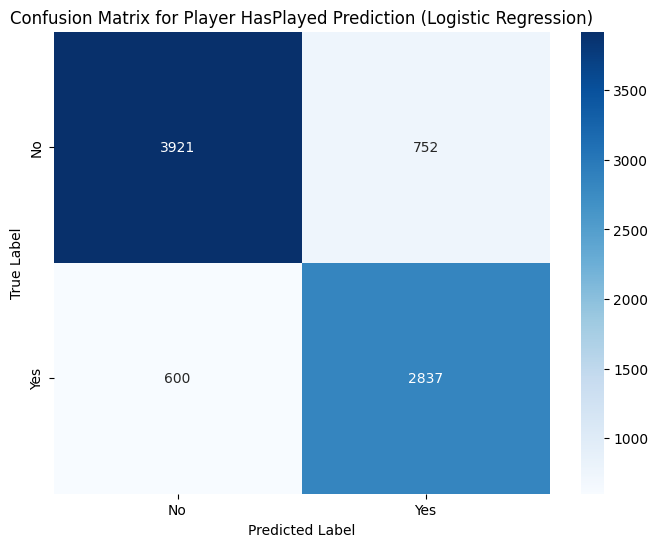

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Evaluate the Logistic Regression model to get the confusion matrix
evaluator_lr = MulticlassClassificationEvaluator(labelCol="HasPlayed_indexed", predictionCol="prediction", metricName="accuracy")
confusion_matrix_data_lr = player_predictions_LR_Model_df.groupBy("HasPlayed_indexed", "prediction").count()

# Collect the data to a Pandas DataFrame for plotting
confusion_matrix_pd_lr = confusion_matrix_data_lr.toPandas()

# Create a pivot table for the confusion matrix
pivot_table_lr = confusion_matrix_pd_lr.pivot(index="HasPlayed_indexed", columns="prediction", values="count").fillna(0)

# Map the indexed labels back to original labels
label_map = {0.0: "No", 1.0: "Yes"}
pivot_table_lr = pivot_table_lr.rename(index=label_map, columns=label_map)

# Plot the confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table_lr, annot=True, fmt=".0f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Player HasPlayed Prediction (Logistic Regression)")
plt.show()

> ***Decision Tree*** prediction in *Confusion Matrix*

25/11/26 14:10:46 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:10:48 WARN DAGScheduler: Broadcasting large task binary with size 1263.9 KiB
25/11/26 14:10:49 WARN DAGScheduler: Broadcasting large task binary with size 1217.4 KiB


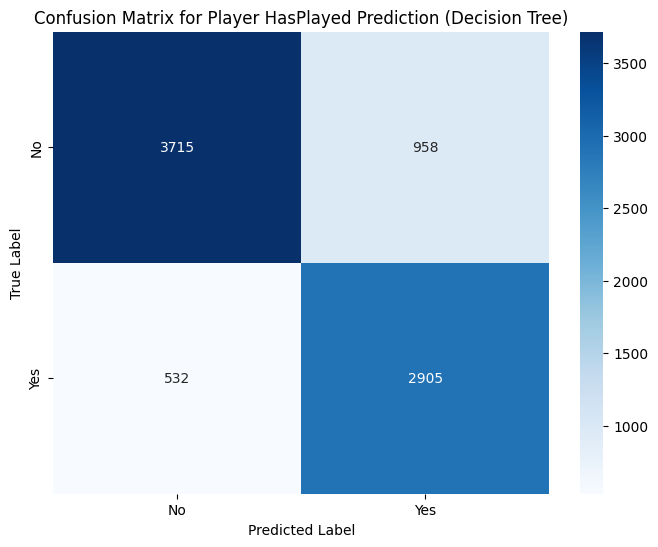

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Evaluate the Decision Tree model to get the confusion matrix
evaluator_dt = MulticlassClassificationEvaluator(labelCol="HasPlayed_indexed", predictionCol="prediction", metricName="accuracy")
confusion_matrix_data_dt = player_dt_predictions_df.groupBy("HasPlayed_indexed", "prediction").count()

# Collect the data to a Pandas DataFrame for plotting
confusion_matrix_pd_dt = confusion_matrix_data_dt.toPandas()

# Create a pivot table for the confusion matrix
pivot_table_dt = confusion_matrix_pd_dt.pivot(index="HasPlayed_indexed", columns="prediction", values="count").fillna(0)

# Map the indexed labels back to original labels
label_map = {0.0: "No", 1.0: "Yes"}
pivot_table_dt = pivot_table_dt.rename(index=label_map, columns=label_map)

# Plot the confusion matrix for Decision Tree
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table_dt, annot=True, fmt=".0f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Player HasPlayed Prediction (Decision Tree)")
plt.show()

> **Random Forest** prediction in *Confusion Matrix*

25/11/26 14:10:51 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
25/11/26 14:10:53 WARN DAGScheduler: Broadcasting large task binary with size 1577.5 KiB
25/11/26 14:10:54 WARN DAGScheduler: Broadcasting large task binary with size 1530.9 KiB


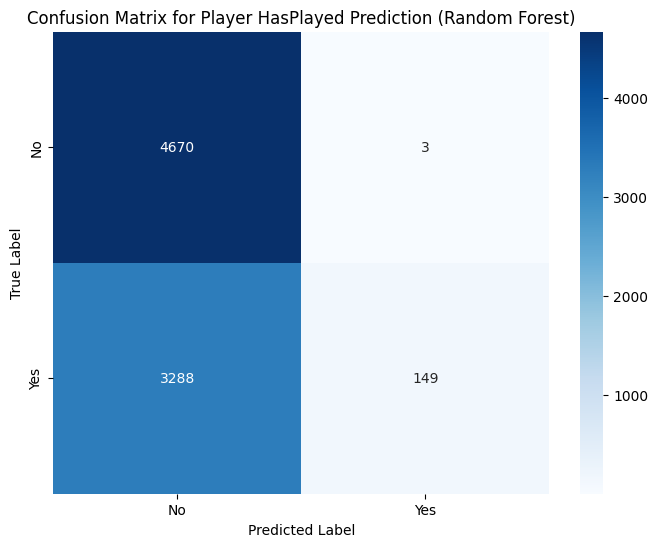

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Evaluate the Random Forest model to get the confusion matrix
evaluator = MulticlassClassificationEvaluator(labelCol="HasPlayed_indexed", predictionCol="prediction", metricName="accuracy")
confusion_matrix_data_rf = player_rf_predictions_df.groupBy("HasPlayed_indexed", "prediction").count()

# Collect the data to a Pandas DataFrame for plotting
confusion_matrix_pd_rf = confusion_matrix_data_rf.toPandas()

# Create a pivot table for the confusion matrix
pivot_table_rf = confusion_matrix_pd_rf.pivot(index="HasPlayed_indexed", columns="prediction", values="count").fillna(0)

# Map the indexed labels back to original labels
# Assuming the StringIndexer mapped 'No' to 0.0 and 'Yes' to 1.0
label_map = {0.0: "No", 1.0: "Yes"}
pivot_table_rf = pivot_table_rf.rename(index=label_map, columns=label_map)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table_rf, annot=True, fmt=".0f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Player HasPlayed Prediction (Random Forest)")
plt.show()

## Conclusion on Player "Has Played" Prediction Models

**Overall Performance:** All three models show a good ability to predict whether a player will play or not, as indicated by their accuracy scores.

* **Logistic Regression:** This model appears to perform *best*, correctly predicting players who play (True Positives) and those who don't (True Negatives). The evaluation metrics (Accuracy, F1 Score, Precision, Recall) shows a good overall predictive capability.

*   **Decision Tree:** The Decision Tree model also gives a strong performance, with a confusion matrix that looks quite similar to the Logistic Regression model, indicating a high number of correct predictions.

*   **Random Forest:** The Random Forest model, while generally a powerful ensemble method, shows a lower performance on this specific task compared to Logistic Regression and Decision Tree, as indicated by its confusion matrix and the evaluation metrics.

**In summary:** Both Logistic Regression and Decision Tree models demonstrate strong and comparable performance in predicting whether a player will play in a gameweek based on the features used. The Random Forest model, surprisingly, did not perform as well in this instance. For this specific prediction task, Logistic Regression and Decision Tree would be preferable based on the evaluation results.

# Match Result Prediction: Supratim

## Generating Match Result Fantasy Points Rolling Average for each Team each Game Week

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType # Import IntegerType

# Convert GameWeek to a numerical type for correct ordering
team_total_points_df = df_FantasyPoints.withColumn("GameWeekNum", F.regexp_replace("GameWeek", "gw", "").cast(IntegerType()))

# Group by GameWeek and Team, then sum FantasyPoints
team_total_points_df = (
    team_total_points_df
    .groupBy("GameWeekNum", "Team", "GameWeek")
    .agg(F.sum("FantasyPoints").alias("TotalFantasyPoints"))
    .orderBy("GameWeekNum", "Team")
)

team_total_points_df.show(50)

25/11/26 14:10:56 WARN DAGScheduler: Broadcasting large task binary with size 1669.2 KiB


+-----------+--------------+--------+------------------+
|GameWeekNum|          Team|GameWeek|TotalFantasyPoints|
+-----------+--------------+--------+------------------+
|          1|       Arsenal|     gw1|              63.0|
|          1|   Aston Villa|     gw1|              41.0|
|          1|   Bournemouth|     gw1|              31.0|
|          1|     Brentford|     gw1|              41.0|
|          1|      Brighton|     gw1|              67.0|
|          1|       Chelsea|     gw1|              22.0|
|          1|Crystal Palace|     gw1|              20.0|
|          1|       Everton|     gw1|              16.0|
|          1|        Fulham|     gw1|              27.0|
|          1|       Ipswich|     gw1|              19.0|
|          1|     Leicester|     gw1|              32.0|
|          1|     Liverpool|     gw1|              62.0|
|          1|      Man City|     gw1|              58.0|
|          1|       Man Utd|     gw1|              58.0|
|          1|     Newcastle|   

***TeamAvgFantasyPoints : - Rolling Average Points***

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

# Calculate the rolling average of total fantasy points for each team
window_spec = Window.partitionBy("Team").orderBy("GameWeekNum").rowsBetween(Window.unboundedPreceding, -1)

team_avg_df = (
    team_total_points_df
    .withColumn("TeamAvgFantasyPoints", F.avg("TotalFantasyPoints").over(window_spec))
)

# For the first gameweek, there are no previous gameweeks, so the average should be 0
team_avg_df = team_avg_df.withColumn(
    "TeamAvgFantasyPoints",
    F.when(F.col("GameWeekNum") == 1, 0)
    .otherwise(F.col("TeamAvgFantasyPoints"))
)

team_avg_df.show(50)

25/11/26 14:11:01 WARN DAGScheduler: Broadcasting large task binary with size 1669.4 KiB
25/11/26 14:11:02 WARN DAGScheduler: Broadcasting large task binary with size 1004.0 KiB


+-----------+-----------+--------+------------------+--------------------+
|GameWeekNum|       Team|GameWeek|TotalFantasyPoints|TeamAvgFantasyPoints|
+-----------+-----------+--------+------------------+--------------------+
|          1|    Arsenal|     gw1|              63.0|                 0.0|
|          2|    Arsenal|     gw2|              61.0|                63.0|
|          3|    Arsenal|     gw3|              26.0|                62.0|
|          4|    Arsenal|     gw4|              57.0|                50.0|
|          5|    Arsenal|     gw5|              36.0|               51.75|
|          6|    Arsenal|     gw6|              42.0|                48.6|
|          7|    Arsenal|     gw7|              47.0|                47.5|
|          8|    Arsenal|     gw8|              15.0|   47.42857142857143|
|          9|    Arsenal|     gw9|              39.0|              43.375|
|         10|    Arsenal|    gw10|              24.0|  42.888888888888886|
|         11|    Arsenal|

> ***Joining the DataFrames to get the FanatasayPoints into MatchResult data***

`Why **TeamAvgFantasyPoints & OpponentTeamAvgFantasyPoints** for

In [ ]:
# Register DataFrames as temporary views for Spark SQL
all_gameweek_matchesResult_df.createOrReplaceTempView("match_results")
team_avg_df.createOrReplaceTempView("team_avg_points")

# Using SPARK SQL to join the dataframes
all_gameweek_matchesResult_with_avg = spark.sql("""
    SELECT
        mr.GameWeek,
        mr.Team,
        mr.OpponentTeam,
        mr.was_home,
        mr.`Team Score`,
        mr.`OpponentTeam Score`,
        mr.Result,
        tap.TeamAvgFantasyPoints,
        otap.TeamAvgFantasyPoints AS OpponentTeamAvgFantasyPoints,
        tap.GameWeekNum  -- Include GameWeekNum
    FROM
        match_results mr
    LEFT JOIN
        team_avg_points tap ON mr.GameWeek = tap.GameWeek AND mr.Team = tap.Team
    LEFT JOIN
        team_avg_points otap ON mr.GameWeek = otap.GameWeek AND mr.OpponentTeam = otap.Team
""")

all_gameweek_matchesResult_with_avg.show(100)

25/11/26 14:11:09 WARN DAGScheduler: Broadcasting large task binary with size 1690.4 KiB
25/11/26 14:11:13 WARN DAGScheduler: Broadcasting large task binary with size 1011.1 KiB
25/11/26 14:11:14 WARN DAGScheduler: Broadcasting large task binary with size 1022.1 KiB
25/11/26 14:11:15 WARN DAGScheduler: Broadcasting large task binary with size 1731.4 KiB
25/11/26 14:11:15 WARN DAGScheduler: Broadcasting large task binary with size 1007.3 KiB
25/11/26 14:11:17 WARN DAGScheduler: Broadcasting large task binary with size 1016.5 KiB
25/11/26 14:11:17 WARN DAGScheduler: Broadcasting large task binary with size 1017.7 KiB


+--------+--------------+--------------+--------+----------+------------------+------+--------------------+----------------------------+-----------+
|GameWeek|          Team|  OpponentTeam|was_home|Team Score|OpponentTeam Score|Result|TeamAvgFantasyPoints|OpponentTeamAvgFantasyPoints|GameWeekNum|
+--------+--------------+--------------+--------+----------+------------------+------+--------------------+----------------------------+-----------+
|     gw2|       Arsenal|   Aston Villa|   False|         2|                 0|   Win|                63.0|                        41.0|          2|
|    gw22|   Aston Villa|       Arsenal|   False|         2|                 2|  Draw|  35.666666666666664|          44.857142857142854|         22|
|    gw35|       Arsenal|   Bournemouth|    True|         1|                 2|  Loss|   46.72727272727273|          40.088235294117645|         35|
|     gw8|       Arsenal|   Bournemouth|   False|         0|                 2|  Loss|   47.42857142857143

25/11/26 14:11:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB


**Remving the GameWeek1, as there is no Rolling Average Fanatasy for these since no previous Games were played**

In [ ]:
all_gameweek_matchesResult_with_avg = all_gameweek_matchesResult_with_avg.select("GameWeekNum", "OpponentTeam", "Team", "was_home", "Result", "TeamAvgFantasyPoints", "OpponentTeamAvgFantasyPoints")

final_matchResults = all_gameweek_matchesResult_with_avg.filter(F.col("GameWeekNum") != 1)
final_matchResults.show(50)

# print("Count for final_matchResults:")
# print(final_matchResults.count())

25/11/26 14:11:24 WARN DAGScheduler: Broadcasting large task binary with size 1690.4 KiB
25/11/26 14:11:28 WARN DAGScheduler: Broadcasting large task binary with size 1011.1 KiB
25/11/26 14:11:28 WARN DAGScheduler: Broadcasting large task binary with size 1022.1 KiB
25/11/26 14:11:29 WARN DAGScheduler: Broadcasting large task binary with size 1704.0 KiB
25/11/26 14:11:29 WARN DAGScheduler: Broadcasting large task binary with size 1007.3 KiB
25/11/26 14:11:31 WARN DAGScheduler: Broadcasting large task binary with size 1016.6 KiB
25/11/26 14:11:31 WARN DAGScheduler: Broadcasting large task binary with size 1017.7 KiB


+-----------+--------------+--------------+--------+------+--------------------+----------------------------+
|GameWeekNum|  OpponentTeam|          Team|was_home|Result|TeamAvgFantasyPoints|OpponentTeamAvgFantasyPoints|
+-----------+--------------+--------------+--------+------+--------------------+----------------------------+
|          2|   Aston Villa|       Arsenal|   False|   Win|                63.0|                        41.0|
|         22|       Arsenal|   Aston Villa|   False|  Draw|  35.666666666666664|          44.857142857142854|
|         35|   Bournemouth|       Arsenal|    True|  Loss|   46.72727272727273|          40.088235294117645|
|          8|   Bournemouth|       Arsenal|   False|  Loss|   47.42857142857143|          33.142857142857146|
|         19|     Brentford|       Arsenal|   False|   Win|   46.55555555555556|           37.77777777777778|
|         32|     Brentford|       Arsenal|    True|  Draw|   44.38709677419355|          38.935483870967744|
|         

25/11/26 14:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1055.5 KiB


## Coding & Encoding the Data

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Define categorical and numerical features
categorical_features = ["Team", "OpponentTeam", "was_home"]
numerical_features = ["GameWeekNum", "TeamAvgFantasyPoints", "OpponentTeamAvgFantasyPoints"]
label_column = "Result"

# Index categorical features
indexers = [StringIndexer(inputCol=col, outputCol=col + "_indexed", handleInvalid="keep") for col in categorical_features + [label_column]]

# One-hot encode indexed categorical features
encoders = [OneHotEncoder(inputCol=col + "_indexed", outputCol=col + "_encoded") for col in categorical_features]

# Assemble features into a single vector
assembler_inputs = [col + "_encoded" for col in categorical_features] + numerical_features
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

# Create a pipeline for feature engineering
feature_pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Fit the pipeline to the data and transform the data
# We will use the data excluding gw1 for training
feature_model = feature_pipeline.fit(final_matchResults)
transformed_df = feature_model.transform(final_matchResults)

transformed_df.show(truncate=False)

25/11/26 14:11:41 WARN DAGScheduler: Broadcasting large task binary with size 1686.7 KiB
25/11/26 14:11:43 WARN DAGScheduler: Broadcasting large task binary with size 1367.0 KiB
25/11/26 14:11:43 WARN DAGScheduler: Broadcasting large task binary with size 1350.0 KiB
25/11/26 14:11:52 WARN DAGScheduler: Broadcasting large task binary with size 1686.7 KiB
25/11/26 14:11:54 WARN DAGScheduler: Broadcasting large task binary with size 1367.3 KiB
25/11/26 14:11:55 WARN DAGScheduler: Broadcasting large task binary with size 1349.9 KiB
25/11/26 14:12:04 WARN DAGScheduler: Broadcasting large task binary with size 1698.5 KiB
25/11/26 14:12:06 WARN DAGScheduler: Broadcasting large task binary with size 1370.8 KiB
25/11/26 14:12:07 WARN DAGScheduler: Broadcasting large task binary with size 1353.7 KiB
25/11/26 14:12:17 WARN DAGScheduler: Broadcasting large task binary with size 1692.2 KiB
25/11/26 14:12:20 WARN DAGScheduler: Broadcasting large task binary with size 1370.8 KiB
25/11/26 14:12:20 WAR

+-----------+--------------+--------------+--------+------+--------------------+----------------------------+------------+--------------------+----------------+--------------+---------------+--------------------+----------------+---------------------------------------------------------------------------------+
|GameWeekNum|OpponentTeam  |Team          |was_home|Result|TeamAvgFantasyPoints|OpponentTeamAvgFantasyPoints|Team_indexed|OpponentTeam_indexed|was_home_indexed|Result_indexed|Team_encoded   |OpponentTeam_encoded|was_home_encoded|features                                                                         |
+-----------+--------------+--------------+--------+------+--------------------+----------------------------+------------+--------------------+----------------+--------------+---------------+--------------------+----------------+---------------------------------------------------------------------------------+
|2          |Aston Villa   |Arsenal       |False   |Win   |63.0 

25/11/26 14:12:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.8 KiB


## Spliting the Data
Split the transformed DataFrame into training and testing sets with an **70/30** ratio

In [ ]:
matchResult_train_df, matchResult_test_df = transformed_df.randomSplit([0.7, 0.3], seed=42)
print("Training data:")
matchResult_train_df.show(5)
print("Testing data:")
matchResult_test_df.show(5)
print("Count of Training data:")
print(matchResult_train_df.count())
print("Count of Testing data:")
print(matchResult_test_df.count())


Training data:


25/11/26 14:12:42 WARN DAGScheduler: Broadcasting large task binary with size 1690.4 KiB
25/11/26 14:12:46 WARN DAGScheduler: Broadcasting large task binary with size 1011.1 KiB
25/11/26 14:12:46 WARN DAGScheduler: Broadcasting large task binary with size 1022.1 KiB
25/11/26 14:12:47 WARN DAGScheduler: Broadcasting large task binary with size 1704.0 KiB
25/11/26 14:12:47 WARN DAGScheduler: Broadcasting large task binary with size 1007.3 KiB
25/11/26 14:12:49 WARN DAGScheduler: Broadcasting large task binary with size 1016.6 KiB
25/11/26 14:12:49 WARN DAGScheduler: Broadcasting large task binary with size 1017.7 KiB
25/11/26 14:12:50 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+-----------+------------+---------+--------+------+--------------------+----------------------------+------------+--------------------+----------------+--------------+---------------+--------------------+----------------+--------------------+
|GameWeekNum|OpponentTeam|     Team|was_home|Result|TeamAvgFantasyPoints|OpponentTeamAvgFantasyPoints|Team_indexed|OpponentTeam_indexed|was_home_indexed|Result_indexed|   Team_encoded|OpponentTeam_encoded|was_home_encoded|            features|
+-----------+------------+---------+--------+------+--------------------+----------------------------+------------+--------------------+----------------+--------------+---------------+--------------------+----------------+--------------------+
|          2| Aston Villa|  Arsenal|   False|   Win|                63.0|                        41.0|         5.0|                 0.0|             0.0|           1.0| (20,[5],[1.0])|      (20,[0],[1.0])|   (2,[0],[1.0])|(45,[5,20,40,42,4...|
|          2| Bournemout

25/11/26 14:12:56 WARN DAGScheduler: Broadcasting large task binary with size 1690.4 KiB
25/11/26 14:12:59 WARN DAGScheduler: Broadcasting large task binary with size 1011.1 KiB
25/11/26 14:12:59 WARN DAGScheduler: Broadcasting large task binary with size 1022.1 KiB
25/11/26 14:13:00 WARN DAGScheduler: Broadcasting large task binary with size 1704.0 KiB
25/11/26 14:13:01 WARN DAGScheduler: Broadcasting large task binary with size 1007.3 KiB
25/11/26 14:13:03 WARN DAGScheduler: Broadcasting large task binary with size 1016.6 KiB
25/11/26 14:13:03 WARN DAGScheduler: Broadcasting large task binary with size 1017.7 KiB
25/11/26 14:13:03 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+-----------+------------+--------------+--------+------+--------------------+----------------------------+------------+--------------------+----------------+--------------+---------------+--------------------+----------------+--------------------+
|GameWeekNum|OpponentTeam|          Team|was_home|Result|TeamAvgFantasyPoints|OpponentTeamAvgFantasyPoints|Team_indexed|OpponentTeam_indexed|was_home_indexed|Result_indexed|   Team_encoded|OpponentTeam_encoded|was_home_encoded|            features|
+-----------+------------+--------------+--------+------+--------------------+----------------------------+------------+--------------------+----------------+--------------+---------------+--------------------+----------------+--------------------+
|          2|   Brentford|     Liverpool|    True|   Win|                62.0|                        41.0|        19.0|                 2.0|             1.0|           1.0|(20,[19],[1.0])|      (20,[2],[1.0])|   (2,[1],[1.0])|(45,[19,22,41,42,...|
|   

25/11/26 14:13:09 WARN DAGScheduler: Broadcasting large task binary with size 1690.4 KiB
25/11/26 14:13:12 WARN DAGScheduler: Broadcasting large task binary with size 1011.1 KiB
25/11/26 14:13:12 WARN DAGScheduler: Broadcasting large task binary with size 1022.1 KiB
25/11/26 14:13:14 WARN DAGScheduler: Broadcasting large task binary with size 1704.0 KiB
25/11/26 14:13:14 WARN DAGScheduler: Broadcasting large task binary with size 1007.3 KiB
25/11/26 14:13:16 WARN DAGScheduler: Broadcasting large task binary with size 1016.6 KiB
25/11/26 14:13:16 WARN DAGScheduler: Broadcasting large task binary with size 1017.7 KiB
25/11/26 14:13:17 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


277
Count of Testing data:


25/11/26 14:13:22 WARN DAGScheduler: Broadcasting large task binary with size 1690.4 KiB
25/11/26 14:13:26 WARN DAGScheduler: Broadcasting large task binary with size 1011.1 KiB
25/11/26 14:13:26 WARN DAGScheduler: Broadcasting large task binary with size 1022.1 KiB
25/11/26 14:13:27 WARN DAGScheduler: Broadcasting large task binary with size 1704.0 KiB
25/11/26 14:13:27 WARN DAGScheduler: Broadcasting large task binary with size 1007.3 KiB
25/11/26 14:13:29 WARN DAGScheduler: Broadcasting large task binary with size 1017.7 KiB
25/11/26 14:13:29 WARN DAGScheduler: Broadcasting large task binary with size 1016.6 KiB
25/11/26 14:13:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


93


## Classification Model

> We have to use Classification as we are trying to predict each match result **Result** each **GameWeekNum** as the answers are `Win or Loss or Draw`

### RandomForest Model

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(labelCol="Result_indexed", featuresCol="features", numTrees=100)

# Train the model
rf_model = rf.fit(matchResult_train_df)

# Make predictions on the test data
predictions_df_rf = rf_model.transform(matchResult_test_df)

predictions_df_rf.show(truncate=False)

25/11/26 14:13:36 WARN DAGScheduler: Broadcasting large task binary with size 1674.5 KiB
25/11/26 14:13:39 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
25/11/26 14:13:40 WARN DAGScheduler: Broadcasting large task binary with size 1694.4 KiB
25/11/26 14:13:42 WARN DAGScheduler: Broadcasting large task binary with size 1000.6 KiB
25/11/26 14:13:42 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB
25/11/26 14:13:48 WARN DAGScheduler: Broadcasting large task binary with size 1674.5 KiB
25/11/26 14:13:51 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
25/11/26 14:13:52 WARN DAGScheduler: Broadcasting large task binary with size 1694.4 KiB
25/11/26 14:13:54 WARN DAGScheduler: Broadcasting large task binary with size 1000.6 KiB
25/11/26 14:13:54 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB
25/11/26 14:13:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/11/26 14:13:55 WARN D

+-----------+--------------+--------------+--------+------+--------------------+----------------------------+------------+--------------------+----------------+--------------+---------------+--------------------+----------------+--------------------------------------------------------------------------------+--------------------------------------------------------------+----------------------------------------------------------------+----------+
|GameWeekNum|OpponentTeam  |Team          |was_home|Result|TeamAvgFantasyPoints|OpponentTeamAvgFantasyPoints|Team_indexed|OpponentTeam_indexed|was_home_indexed|Result_indexed|Team_encoded   |OpponentTeam_encoded|was_home_encoded|features                                                                        |rawPrediction                                                 |probability                                                     |prediction|
+-----------+--------------+--------------+--------+------+--------------------+--------------------

In [ ]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Result_indexed", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_df_rf)
print(f"RandomForest, Accuracy: {accuracy}")

# You can also evaluate other metrics like F1-score, precision, and recall
evaluator.setMetricName("f1")
f1 = evaluator.evaluate(predictions_df_rf)
print(f"RandomForest, F1 Score: {f1}")

evaluator.setMetricName("weightedPrecision")
weightedPrecision = evaluator.evaluate(predictions_df_rf)
print(f"RandomForest, Weighted Precision: {weightedPrecision}")

evaluator.setMetricName("weightedRecall")
weightedRecall = evaluator.evaluate(predictions_df_rf)
print(f"RandomForest, Weighted Recall: {weightedRecall}")

25/11/26 14:14:29 WARN DAGScheduler: Broadcasting large task binary with size 1674.5 KiB
25/11/26 14:14:33 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
25/11/26 14:14:34 WARN DAGScheduler: Broadcasting large task binary with size 1694.4 KiB
25/11/26 14:14:36 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB
25/11/26 14:14:36 WARN DAGScheduler: Broadcasting large task binary with size 1000.6 KiB
25/11/26 14:14:37 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


RandomForest, Accuracy: 0.5053763440860215


25/11/26 14:14:43 WARN DAGScheduler: Broadcasting large task binary with size 1674.5 KiB
25/11/26 14:14:46 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
25/11/26 14:14:47 WARN DAGScheduler: Broadcasting large task binary with size 1694.4 KiB
25/11/26 14:14:49 WARN DAGScheduler: Broadcasting large task binary with size 1000.6 KiB
25/11/26 14:14:49 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB
25/11/26 14:14:49 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


RandomForest, F1 Score: 0.477173781767781


25/11/26 14:14:55 WARN DAGScheduler: Broadcasting large task binary with size 1674.5 KiB
25/11/26 14:14:59 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
25/11/26 14:15:00 WARN DAGScheduler: Broadcasting large task binary with size 1694.4 KiB
25/11/26 14:15:02 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB
25/11/26 14:15:02 WARN DAGScheduler: Broadcasting large task binary with size 1000.6 KiB
25/11/26 14:15:02 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


RandomForest, Weighted Precision: 0.5161290322580645


25/11/26 14:15:08 WARN DAGScheduler: Broadcasting large task binary with size 1674.5 KiB
25/11/26 14:15:12 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
25/11/26 14:15:13 WARN DAGScheduler: Broadcasting large task binary with size 1694.4 KiB
25/11/26 14:15:15 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB
25/11/26 14:15:15 WARN DAGScheduler: Broadcasting large task binary with size 1000.6 KiB
25/11/26 14:15:15 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


RandomForest, Weighted Recall: 0.5053763440860215


25/11/26 14:15:21 WARN DAGScheduler: Broadcasting large task binary with size 1690.4 KiB
25/11/26 14:15:25 WARN DAGScheduler: Broadcasting large task binary with size 1011.1 KiB
25/11/26 14:15:25 WARN DAGScheduler: Broadcasting large task binary with size 1022.1 KiB
25/11/26 14:15:26 WARN DAGScheduler: Broadcasting large task binary with size 1704.0 KiB
25/11/26 14:15:26 WARN DAGScheduler: Broadcasting large task binary with size 1007.3 KiB
25/11/26 14:15:28 WARN DAGScheduler: Broadcasting large task binary with size 1016.6 KiB
25/11/26 14:15:28 WARN DAGScheduler: Broadcasting large task binary with size 1017.7 KiB
25/11/26 14:15:28 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
25/11/26 14:15:29 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


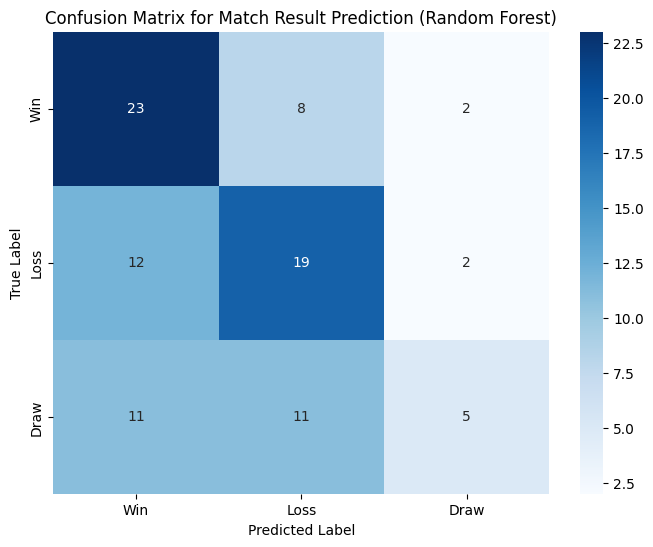

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Evaluate the Random Forest model to get the confusion matrix
evaluator_rf = MulticlassClassificationEvaluator(labelCol="Result_indexed", predictionCol="prediction", metricName="accuracy")
confusion_matrix_data_rf = predictions_df_rf.groupBy("Result_indexed", "prediction").count()

# Collect the data to a Pandas DataFrame for plotting
confusion_matrix_pd_rf = confusion_matrix_data_rf.toPandas()

# Create a pivot table for the confusion matrix
pivot_table_rf = confusion_matrix_pd_rf.pivot(index="Result_indexed", columns="prediction", values="count").fillna(0)

# Map the indexed labels back to original labels
# Assuming the StringIndexer mapped 'Win' to 0.0, 'Loss' to 1.0, and 'Draw' to 2.0
label_map = {0.0: "Win", 1.0: "Loss", 2.0: "Draw"}
pivot_table_rf = pivot_table_rf.rename(index=label_map, columns=label_map)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table_rf, annot=True, fmt=".0f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Match Result Prediction (Random Forest)")
plt.show()

### DecissionTree Model

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="Result_indexed")

# Train the model on the training data
dt_model = dt.fit(matchResult_train_df)

# Make predictions on the test data
predictions_DT_df = dt_model.transform(matchResult_test_df)

predictions_DT_df.show(truncate=False)

25/11/26 14:15:35 WARN DAGScheduler: Broadcasting large task binary with size 1674.5 KiB
25/11/26 14:15:39 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
25/11/26 14:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1694.4 KiB
25/11/26 14:15:42 WARN DAGScheduler: Broadcasting large task binary with size 1000.6 KiB
25/11/26 14:15:42 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB
25/11/26 14:15:48 WARN DAGScheduler: Broadcasting large task binary with size 1674.5 KiB
25/11/26 14:15:51 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
25/11/26 14:15:52 WARN DAGScheduler: Broadcasting large task binary with size 1694.5 KiB
25/11/26 14:15:54 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB
25/11/26 14:15:54 WARN DAGScheduler: Broadcasting large task binary with size 1000.6 KiB
25/11/26 14:15:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/11/26 14:15:55 WARN D

+-----------+--------------+--------------+--------+------+--------------------+----------------------------+------------+--------------------+----------------+--------------+---------------+--------------------+----------------+--------------------------------------------------------------------------------+--------------------+---------------------------------------------------------------+----------+
|GameWeekNum|OpponentTeam  |Team          |was_home|Result|TeamAvgFantasyPoints|OpponentTeamAvgFantasyPoints|Team_indexed|OpponentTeam_indexed|was_home_indexed|Result_indexed|Team_encoded   |OpponentTeam_encoded|was_home_encoded|features                                                                        |rawPrediction       |probability                                                    |prediction|
+-----------+--------------+--------------+--------+------+--------------------+----------------------------+------------+--------------------+----------------+--------------+-----------

In [ ]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Result_indexed", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_DT_df)
print(f"DecissionTree, Accuracy: {accuracy}")

# You can also evaluate other metrics like F1-score, precision, and recall
evaluator.setMetricName("f1")
f1 = evaluator.evaluate(predictions_DT_df)
print(f"DecissionTree, F1 Score: {f1}")

evaluator.setMetricName("weightedPrecision")
weightedPrecision = evaluator.evaluate(predictions_DT_df)
print(f"DecissionTree, Weighted Precision: {weightedPrecision}")

evaluator.setMetricName("weightedRecall")
weightedRecall = evaluator.evaluate(predictions_DT_df)
print(f"DecissionTree, Weighted Recall: {weightedRecall}")

25/11/26 14:16:17 WARN DAGScheduler: Broadcasting large task binary with size 1674.5 KiB
25/11/26 14:16:22 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
25/11/26 14:16:23 WARN DAGScheduler: Broadcasting large task binary with size 1694.4 KiB
25/11/26 14:16:25 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB
25/11/26 14:16:25 WARN DAGScheduler: Broadcasting large task binary with size 1000.6 KiB
25/11/26 14:16:25 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


DecissionTree, Accuracy: 0.4731182795698925


25/11/26 14:16:31 WARN DAGScheduler: Broadcasting large task binary with size 1674.5 KiB
25/11/26 14:16:34 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
25/11/26 14:16:35 WARN DAGScheduler: Broadcasting large task binary with size 1694.4 KiB
25/11/26 14:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1000.6 KiB
25/11/26 14:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB
25/11/26 14:16:37 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


DecissionTree, F1 Score: 0.4484051741453421


25/11/26 14:16:43 WARN DAGScheduler: Broadcasting large task binary with size 1674.5 KiB
25/11/26 14:16:46 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
25/11/26 14:16:47 WARN DAGScheduler: Broadcasting large task binary with size 1694.4 KiB
25/11/26 14:16:49 WARN DAGScheduler: Broadcasting large task binary with size 1000.6 KiB
25/11/26 14:16:49 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB
25/11/26 14:16:49 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


DecissionTree, Weighted Precision: 0.5588366506520248


25/11/26 14:16:55 WARN DAGScheduler: Broadcasting large task binary with size 1674.5 KiB
25/11/26 14:16:58 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
25/11/26 14:16:59 WARN DAGScheduler: Broadcasting large task binary with size 1694.4 KiB
25/11/26 14:17:01 WARN DAGScheduler: Broadcasting large task binary with size 1000.6 KiB
25/11/26 14:17:01 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB
25/11/26 14:17:02 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


DecissionTree, Weighted Recall: 0.4731182795698925


25/11/26 14:17:08 WARN DAGScheduler: Broadcasting large task binary with size 1690.4 KiB
25/11/26 14:17:11 WARN DAGScheduler: Broadcasting large task binary with size 1011.1 KiB
25/11/26 14:17:11 WARN DAGScheduler: Broadcasting large task binary with size 1022.1 KiB
25/11/26 14:17:12 WARN DAGScheduler: Broadcasting large task binary with size 1704.0 KiB
25/11/26 14:17:12 WARN DAGScheduler: Broadcasting large task binary with size 1007.3 KiB
25/11/26 14:17:14 WARN DAGScheduler: Broadcasting large task binary with size 1017.7 KiB
25/11/26 14:17:14 WARN DAGScheduler: Broadcasting large task binary with size 1016.6 KiB
25/11/26 14:17:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/11/26 14:17:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


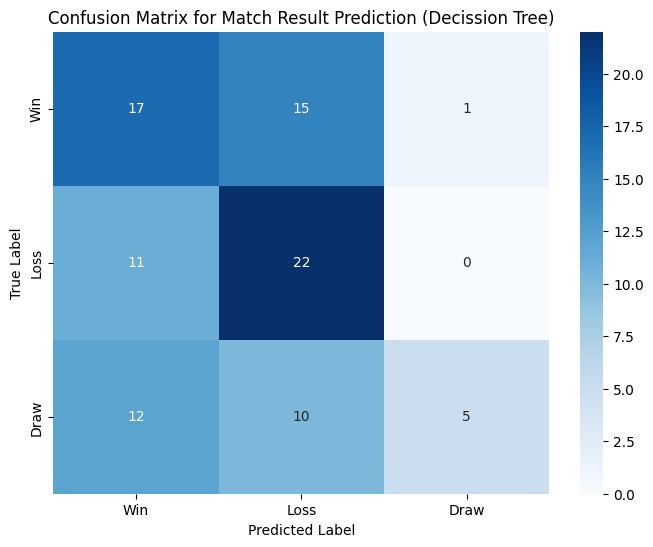

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Evaluate the Random Forest model to get the confusion matrix
evaluator_rf = MulticlassClassificationEvaluator(labelCol="Result_indexed", predictionCol="prediction", metricName="accuracy")
confusion_matrix_data_DT = predictions_DT_df.groupBy("Result_indexed", "prediction").count()

# Collect the data to a Pandas DataFrame for plotting
confusion_matrix_pd_DT = confusion_matrix_data_DT.toPandas()

# Create a pivot table for the confusion matrix
pivot_table_DT = confusion_matrix_pd_DT.pivot(index="Result_indexed", columns="prediction", values="count").fillna(0)

# Map the indexed labels back to original labels
# Assuming the StringIndexer mapped 'Win' to 0.0, 'Loss' to 1.0, and 'Draw' to 2.0
label_map = {0.0: "Win", 1.0: "Loss", 2.0: "Draw"}
pivot_table_DT = pivot_table_DT.rename(index=label_map, columns=label_map)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table_DT, annot=True, fmt=".0f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Match Result Prediction (Decission Tree)")
plt.show()

## **Conclusion**

This project presents a scalable, data-driven system for predicting Fantasy Premier League (FPL) outcomes during the 2024/25 season. By integrating structured match data, custom fantasy point logic,  and machine learning models, the system enables users to make informed decisions for fantasy team
selection and match result forecasting.
We developed a modular pipeline that collects and processes Gameweek-wise data from public repositories, stores it in Google Drive, and transforms it using Spark and Python. Feature engineering was guided by a custom fantasy point system tailored to player positions and match events. This scoring logic formed the foundation for simulating player performance and optimizing team selection.
Three core prediction tasks were addressed:
• Player Participation using classification models (Logistic Regression, Decision Tree, Random
Forest)
• Fantasy Point Estimation using regression models (Linear Regression with R² ≈ 0.968)
• Match Result Prediction using ensemble classifiers (Random Forest, Decision Tree)
The system was evaluated using standard metrics such as Accuracy, F1 Score, RMSE, and MAE, and designed for scalability with support for multi-season data, low-latency inference, and future integration with real-time streaming platforms. Ultimately, this work bridges the gap between match score prediction and fantasy team optimization,laying the groundwork for future enhancements in sports analytics. It empowers users to move beyond intuition and rely on data-driven insights for competitive fantasy gameplay.